<a href="https://colab.research.google.com/github/Alejandro2195/Multiple-File-Protein-prediction-in-AlphaFold2-ColabFold/blob/main/AlphaFold2%20modified%20code%20for%20multiple%20protein%20prediction%20-%20parallel%20processing%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.2: AlphaFold2 using MMseqs2 modified by Alejandro José Gómez García (https://github.com/Alejandro2195)

All changes in: https://github.com/Alejandro2195/Multiple-File-Protein-prediction-in-AlphaFold2-ColabFold

### Parallel processing:
This notebook has the addition of parallel processing of the sequences, which can greatly speed up the processing depending on the computer equipment available. By default, it is configured to process 4 streams in parallel. If you want to change it, just modify the "workers_limit" parameter.

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript.
Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

The query sequence that appears by default is not important, when executing the code you will be asked to load all the files with their sequences. There is no limit to the number of files or the number of sequences to be analyzed. The rest of the parameters can be set interactively.

The number of models to be predicted per sequence is set to 1 by default. If you want to change it, you must do so in its respective section of the code, specifically in the "num_models" parameter.

In [2]:
#@title Install dependencies
%%bash -s $use_amber $use_templates $python_version

set -e

USE_AMBER=$1
USE_TEMPLATES=$2
PYTHON_VERSION=$3

if [ ! -f COLABFOLD_READY ]; then
  echo "installing colabfold..."
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold" "tensorflow-cpu==2.11.0"
  pip uninstall -yq jax jaxlib
  pip install -q "jax[cuda]==0.3.25" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


  # for debugging
  ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
  ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    echo "installing conda..."
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  echo "installing hhsuite..."
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python="${PYTHON_VERSION}" 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  echo "installing amber..."
  conda install -y -q -c conda-forge openmm=7.5.1 python="${PYTHON_VERSION}" pdbfixer cryptography==38.0.4 2>&1 1>/dev/null
  touch AMBER_READY
fi

installing colabfold...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 115.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.0/242.0 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 63.3 MB/s eta 0:00:00
     ━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.2 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.3.5 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


## Execute AlphaFold (All in One) - Parallel Processing

Saving Tilletiaria anomala.txt to Tilletiaria anomala.txt
Saving Piptocephalis cylindrospora.txt to Piptocephalis cylindrospora.txt
Saving Tilletia walkeri.txt to Tilletia walkeri.txt
Processed: Tilletiaria anomala.txt
Jobname: Tilletiariaanomala_eeb05
Num_sequences: 10
Processed: Piptocephalis cylindrospora.txt
Jobname: Piptocephaliscylindrospora_be294
Num_sequences: 18
Processed: Tilletia walkeri.txt
Jobname: Tilletiawalkeri_fe55c
Num_sequences: 17
2023-09-15 06:09:01,480 Running on GPU
2023-09-15 06:09:01,579 Running on GPU
2023-09-15 06:09:01,718 Found 4 citations for tools or databases
2023-09-15 06:09:01,725 Query 1/10: KDN49942.1 (length 106)


SUBMIT:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:09:01,750 Running on GPU
2023-09-15 06:09:01,759 Found 4 citations for tools or databases
2023-09-15 06:09:01,770 Query 1/18: RKP13286.1 (length 87)


SUBMIT:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:09:01,903 Found 4 citations for tools or databases
2023-09-15 06:09:01,928 Query 1/17: KAE8215418.1 (length 154)


2023-09-15 06:09:02,154 Sleeping for 10s. Reason: PENDING


2023-09-15 06:09:02,214 Sleeping for 7s. Reason: PENDING


2023-09-15 06:09:02,348 Sleeping for 6s. Reason: PENDING


2023-09-15 06:09:08,832 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:08 remaining: 00:00]


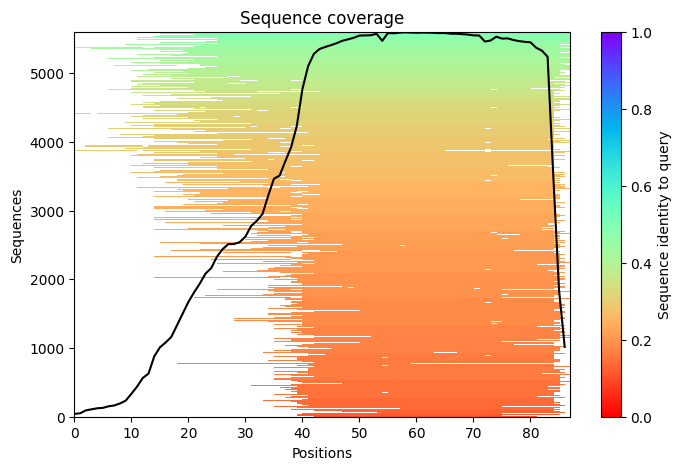

2023-09-15 06:09:12,723 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:09:17,354 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:19 remaining: 00:00]

2023-09-15 06:09:21,630 Padding length to 97


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:20 remaining: 00:00]


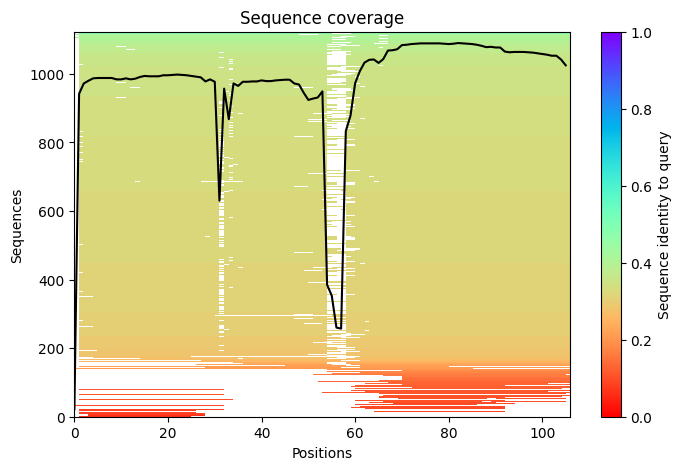

COMPLETE: 100%|██████████| 150/150 [elapsed: 00:25 remaining: 00:00]


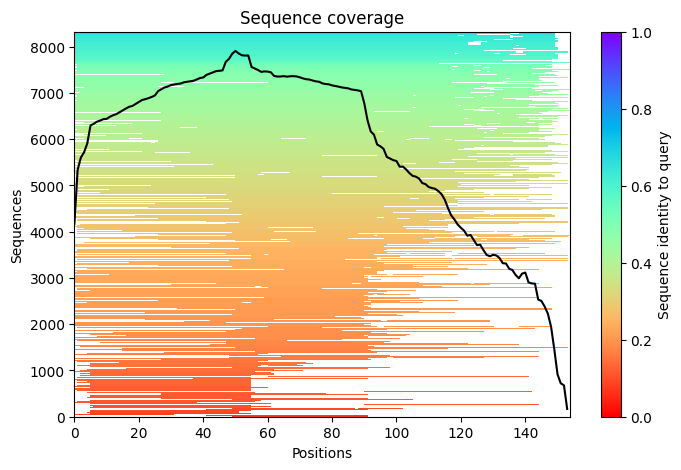

2023-09-15 06:09:48,641 Padding length to 116
2023-09-15 06:10:01,541 Padding length to 164
2023-09-15 06:10:40,512 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=64.9 pTM=0.42
2023-09-15 06:10:49,457 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=67.8 pTM=0.436 tol=2.75
2023-09-15 06:11:01,866 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=67.9 pTM=0.441 tol=1.92
2023-09-15 06:11:11,339 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=79.9 pTM=0.581
2023-09-15 06:11:17,311 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=68.3 pTM=0.444 tol=3.45
2023-09-15 06:11:17,340 alphafold2_ptm_model_1_seed_000 took 115.7s (3 recycles)


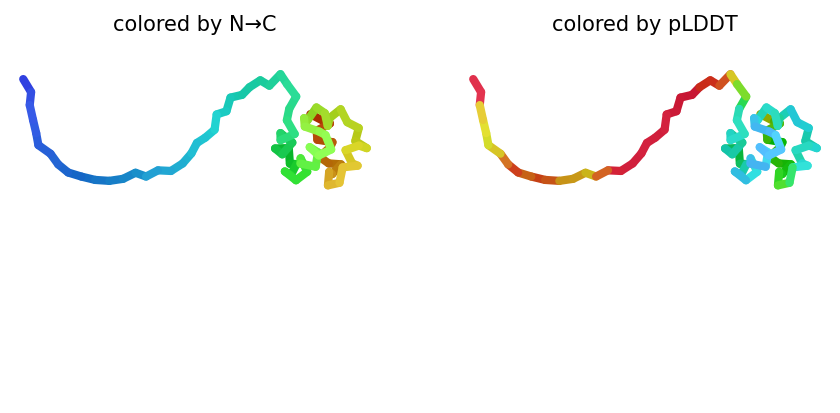

2023-09-15 06:11:17,781 reranking models by 'plddt' metric
2023-09-15 06:11:17,801 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=68.3 pTM=0.444
2023-09-15 06:11:22,271 Query 2/18: RKP14635.1 (length 115)


2023-09-15 06:11:22,920 Sleeping for 7s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:11:23,490 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.2 pTM=0.616 tol=0.807


2023-09-15 06:11:30,553 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▍         | 7/150 [elapsed: 00:08 remaining: 02:48]

2023-09-15 06:11:32,930 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=84.9 pTM=0.644 tol=0.456


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:16 remaining: 00:00]


2023-09-15 06:11:42,085 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=85.8 pTM=0.651 tol=0.276
2023-09-15 06:11:42,106 alphafold2_ptm_model_1_seed_000 took 113.4s (3 recycles)


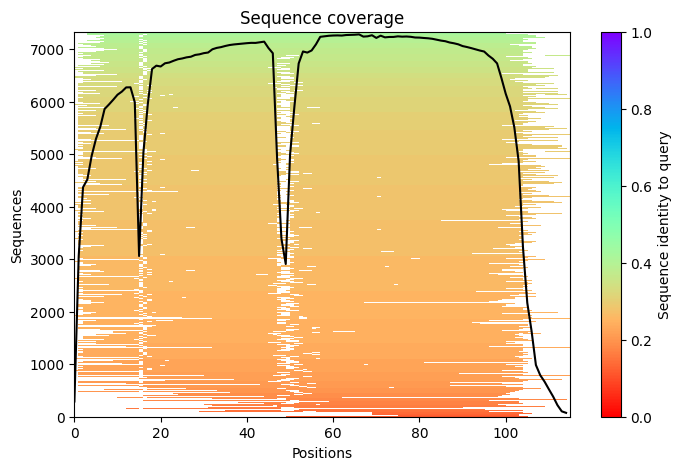

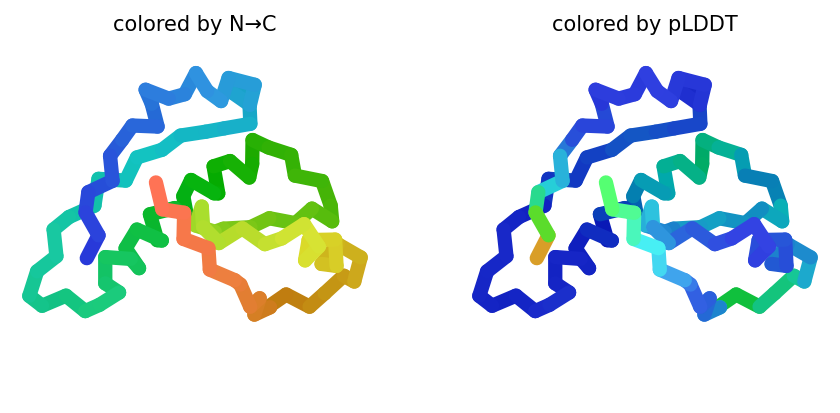

2023-09-15 06:11:42,742 reranking models by 'plddt' metric
2023-09-15 06:11:42,761 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=85.8 pTM=0.651
2023-09-15 06:11:46,320 Query 2/10: KDN52532.1 (length 142)


2023-09-15 06:11:47,028 Sleeping for 9s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:11:48,807 Padding length to 125


2023-09-15 06:11:56,828 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:19 remaining: 00:00]


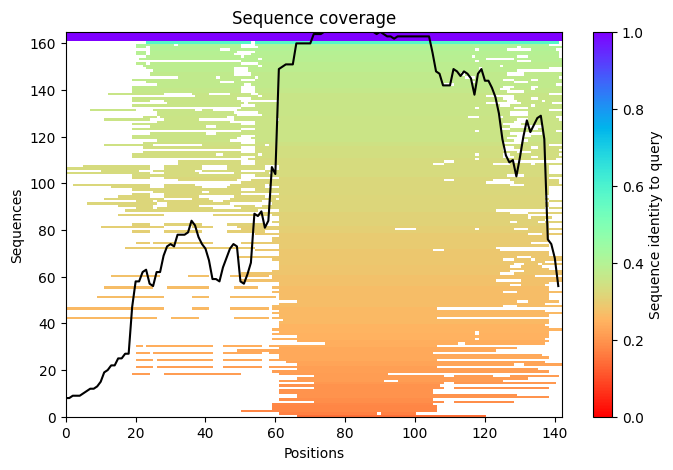

2023-09-15 06:12:10,557 Padding length to 152
2023-09-15 06:12:22,757 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=77.4 pTM=0.422
2023-09-15 06:12:37,211 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=76.8 pTM=0.429 tol=6.13
2023-09-15 06:12:52,284 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=76.5 pTM=0.426 tol=2.23
2023-09-15 06:13:07,016 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.7 pTM=0.422 tol=2.97
2023-09-15 06:13:07,046 alphafold2_ptm_model_1_seed_000 took 185.5s (3 recycles)


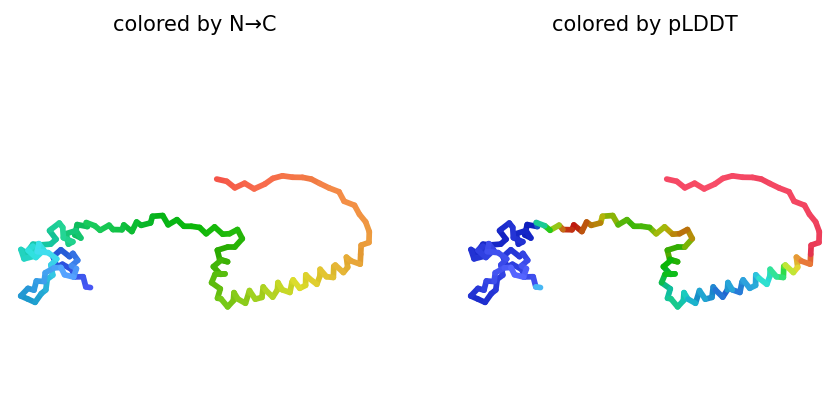

2023-09-15 06:13:07,603 reranking models by 'plddt' metric
2023-09-15 06:13:07,617 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.7 pTM=0.422
2023-09-15 06:13:12,851 Query 2/17: KAE8211394.1 (length 173)


2023-09-15 06:13:13,518 Sleeping for 8s. Reason: PENDING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:10 remaining: 00:00]


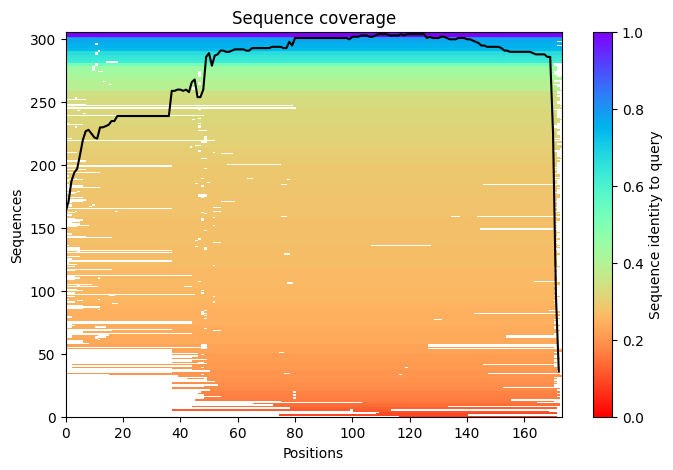

2023-09-15 06:13:33,859 Padding length to 183
2023-09-15 06:14:02,820 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=65.9 pTM=0.345
2023-09-15 06:14:03,847 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=89.8 pTM=0.775
2023-09-15 06:14:24,236 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=89.8 pTM=0.785 tol=0.276
2023-09-15 06:14:27,519 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66.8 pTM=0.357 tol=5.61
2023-09-15 06:14:44,027 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=90.1 pTM=0.789 tol=0.124
2023-09-15 06:14:51,939 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66.9 pTM=0.366 tol=3.33
2023-09-15 06:15:03,530 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=90.1 pTM=0.789 tol=0.085
2023-09-15 06:15:03,546 alphafold2_ptm_model_1_seed_000 took 194.7s (3 recycles)


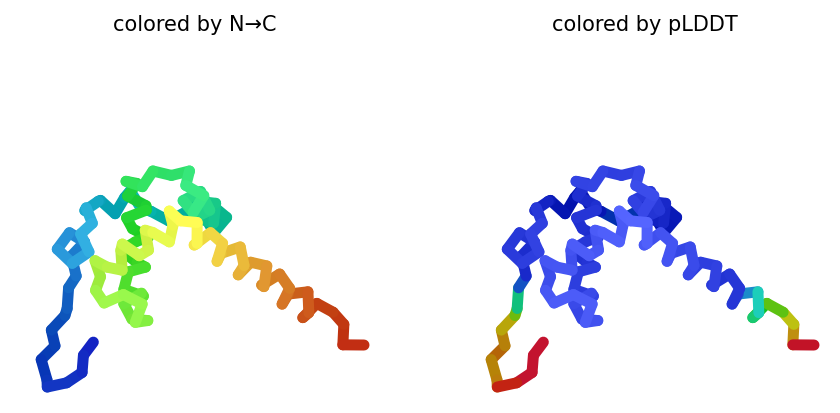

2023-09-15 06:15:04,366 reranking models by 'plddt' metric
2023-09-15 06:15:04,393 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=90.1 pTM=0.789
2023-09-15 06:15:07,483 Query 3/18: RKP15037.1 (length 119)


2023-09-15 06:15:08,110 Sleeping for 8s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:15:09,883 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.9 pTM=0.372 tol=1.93
2023-09-15 06:15:09,901 alphafold2_ptm_model_1_seed_000 took 179.3s (3 recycles)


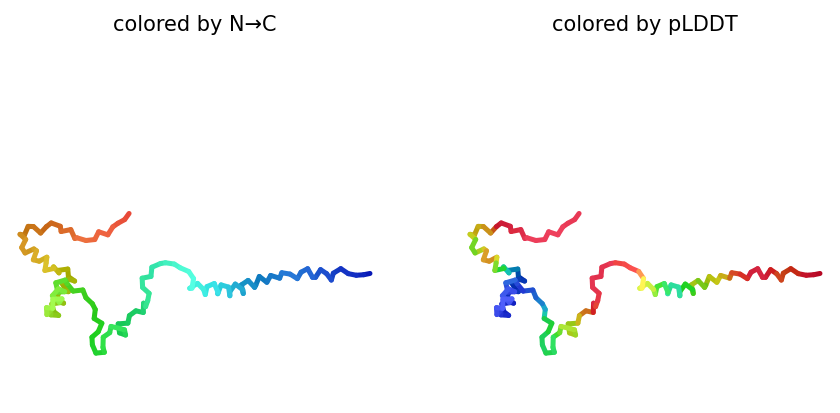

2023-09-15 06:15:10,213 reranking models by 'plddt' metric
2023-09-15 06:15:10,237 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.9 pTM=0.372
2023-09-15 06:15:12,128 Query 3/10: KDN53390.1 (length 218)


2023-09-15 06:15:12,574 Sleeping for 6s. Reason: PENDING


2023-09-15 06:15:16,785 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:15:19,148 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:15:24,761 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:18 remaining: 00:00]


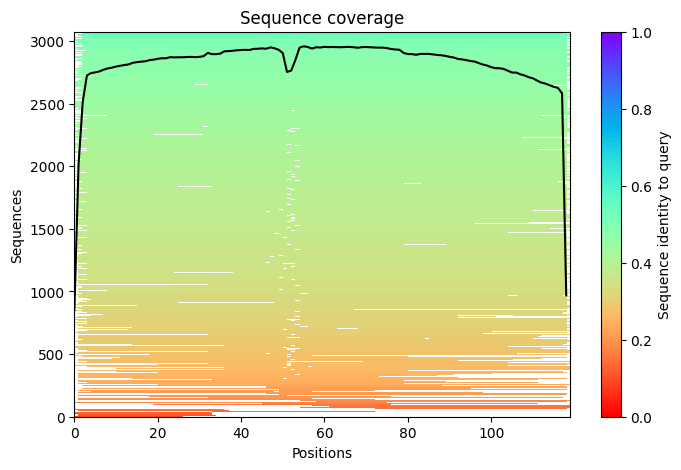

2023-09-15 06:15:31,357 Padding length to 125


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:24 remaining: 00:00]


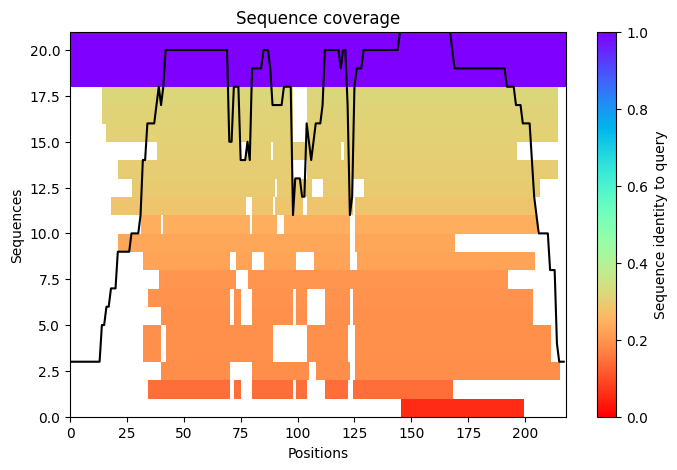

2023-09-15 06:15:42,254 Padding length to 228
2023-09-15 06:15:50,643 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=92.8 pTM=0.771
2023-09-15 06:16:02,257 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=86.2 pTM=0.826
2023-09-15 06:16:10,803 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=92.4 pTM=0.763 tol=0.166
2023-09-15 06:16:31,341 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=92.2 pTM=0.763 tol=0.102
2023-09-15 06:16:32,671 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.9 pTM=0.83 tol=2.78
2023-09-15 06:16:51,130 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=92.2 pTM=0.762 tol=0.0551
2023-09-15 06:16:51,142 alphafold2_ptm_model_1_seed_000 took 79.8s (3 recycles)


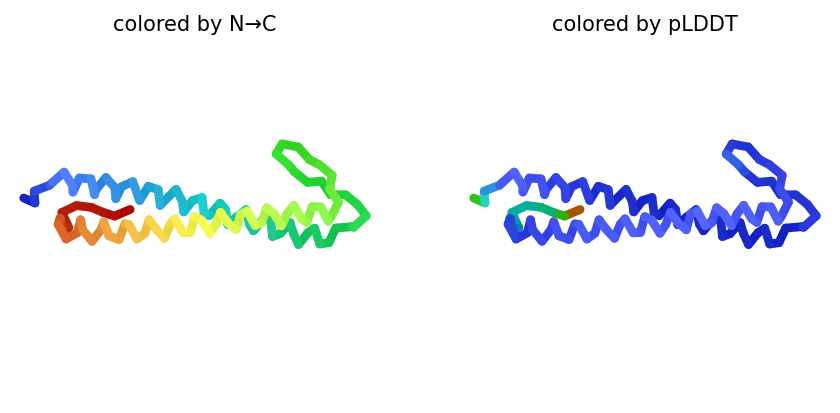

2023-09-15 06:16:51,525 reranking models by 'plddt' metric
2023-09-15 06:16:51,554 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=92.2 pTM=0.762
2023-09-15 06:16:54,172 Query 4/18: RKP12161.1 (length 192)


2023-09-15 06:16:54,765 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:16:57,211 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=87.9 pTM=0.832 tol=4.08


2023-09-15 06:17:05,409 Sleeping for 8s. Reason: RUNNING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:11 remaining: 02:36]

2023-09-15 06:17:12,817 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=88.2 pTM=0.838 tol=0.519
2023-09-15 06:17:12,830 alphafold2_ptm_model_1_seed_000 took 218.9s (3 recycles)


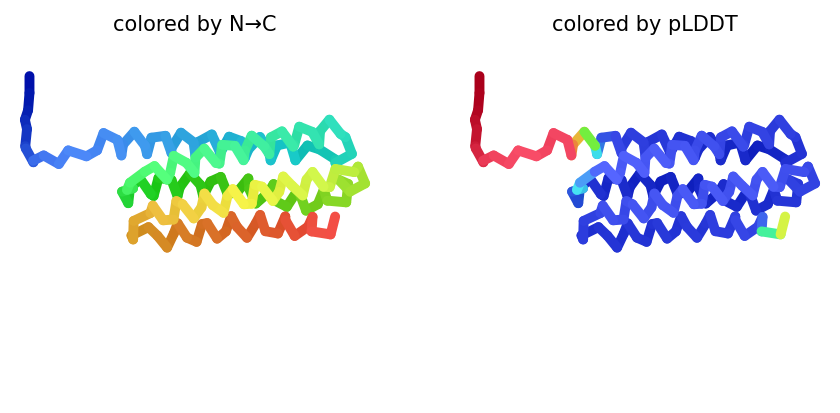

2023-09-15 06:17:13,204 reranking models by 'plddt' metric
2023-09-15 06:17:13,226 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=88.2 pTM=0.838


2023-09-15 06:17:14,094 Sleeping for 6s. Reason: RUNNING


RUNNING:  12%|█▏        | 18/150 [elapsed: 00:19 remaining: 02:25]

2023-09-15 06:17:15,308 Query 3/17: KAE8213367.1 (length 181)


2023-09-15 06:17:15,792 Sleeping for 10s. Reason: PENDING


2023-09-15 06:17:20,780 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:17:26,448 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:17:26,454 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:17:31,930 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:40 remaining: 00:00]


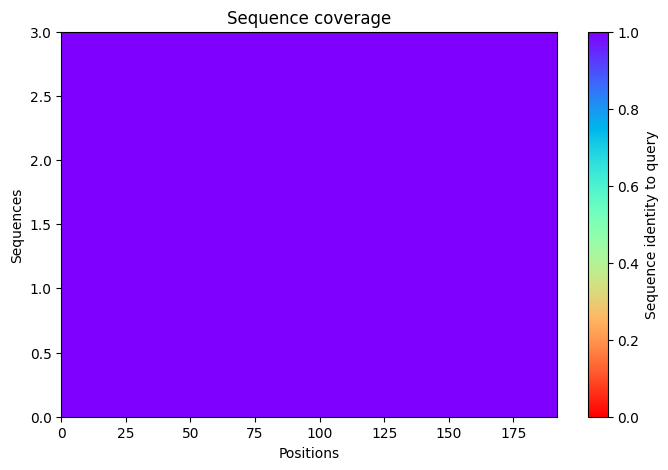

2023-09-15 06:17:39,808 Padding length to 202


2023-09-15 06:17:40,640 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:17:49,297 Sleeping for 7s. Reason: RUNNING


RUNNING:  21%|██        | 31/150 [elapsed: 00:34 remaining: 02:09]

2023-09-15 06:17:49,606 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=51 pTM=0.222


2023-09-15 06:17:56,956 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:18:07,639 Sleeping for 6s. Reason: RUNNING


RUNNING:  32%|███▏      | 48/150 [elapsed: 00:52 remaining: 01:50]

2023-09-15 06:18:10,493 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=49.6 pTM=0.22 tol=5.46


2023-09-15 06:18:14,388 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:05 remaining: 00:00]


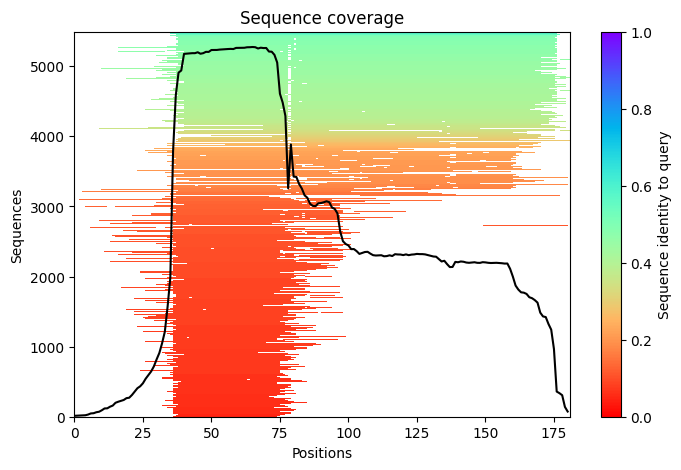

2023-09-15 06:18:31,515 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=49.5 pTM=0.225 tol=1.89
2023-09-15 06:18:32,000 Padding length to 183
2023-09-15 06:19:03,543 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=72 pTM=0.651
2023-09-15 06:19:11,969 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=49.4 pTM=0.231 tol=1.69
2023-09-15 06:19:11,983 alphafold2_ptm_model_1_seed_000 took 209.7s (3 recycles)


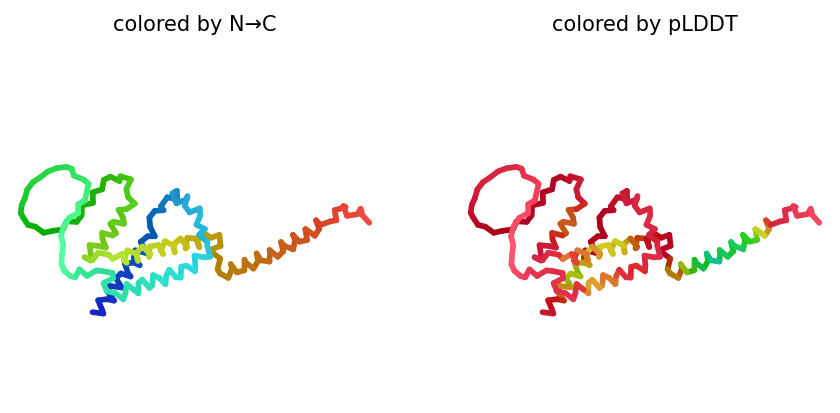

2023-09-15 06:19:12,684 reranking models by 'plddt' metric
2023-09-15 06:19:12,702 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=49.4 pTM=0.231
2023-09-15 06:19:15,432 Query 4/10: KDN50800.1 (length 247)


2023-09-15 06:19:16,036 Sleeping for 10s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:19:23,524 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=71.5 pTM=0.634 tol=2.51


2023-09-15 06:19:26,633 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:19:32,220 Sleeping for 7s. Reason: RUNNING


RUNNING:  10%|█         | 15/150 [elapsed: 00:16 remaining: 02:30]

2023-09-15 06:19:39,554 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.9 pTM=0.638 tol=1.86


2023-09-15 06:19:39,983 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:19:50,572 Sleeping for 6s. Reason: RUNNING


RUNNING:  21%|██▏       | 32/150 [elapsed: 00:35 remaining: 02:08]

2023-09-15 06:19:55,539 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.6 pTM=0.647 tol=2.91
2023-09-15 06:19:55,562 alphafold2_ptm_model_1_seed_000 took 83.5s (3 recycles)


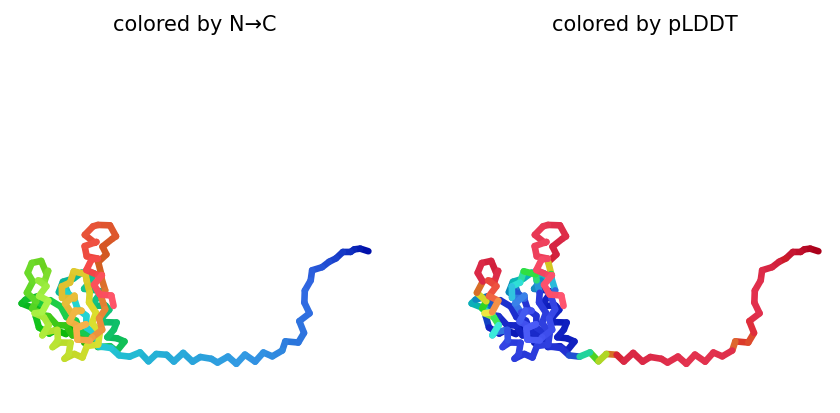

2023-09-15 06:19:56,279 reranking models by 'plddt' metric
2023-09-15 06:19:56,289 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.6 pTM=0.647


2023-09-15 06:19:57,220 Sleeping for 7s. Reason: RUNNING


RUNNING:  25%|██▌       | 38/150 [elapsed: 00:41 remaining: 02:02]

2023-09-15 06:20:00,021 Query 4/17: KAE8210102.1 (length 211)


2023-09-15 06:20:00,487 Sleeping for 8s. Reason: PENDING


2023-09-15 06:20:04,720 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:20:09,110 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:20:13,347 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:20:17,584 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:24 remaining: 00:00]


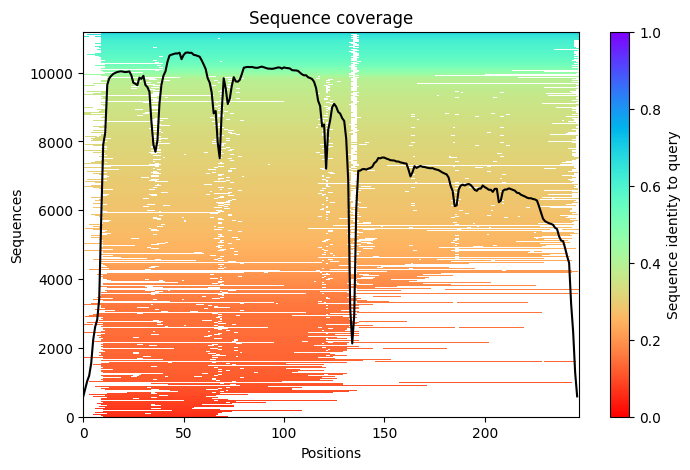

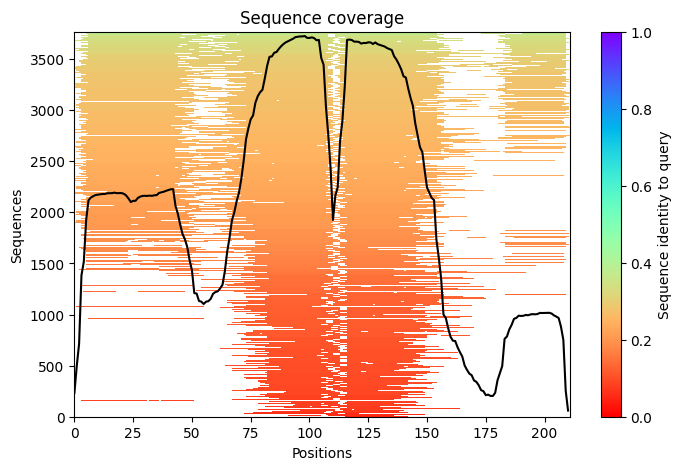

2023-09-15 06:20:32,633 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=41.1 pTM=0.296
2023-09-15 06:20:37,094 Padding length to 221
2023-09-15 06:20:42,947 Padding length to 257
2023-09-15 06:20:51,325 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=39.5 pTM=0.314 tol=8.43
2023-09-15 06:21:08,446 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=41.1 pTM=0.337 tol=2.45
2023-09-15 06:21:27,141 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=40.7 pTM=0.332 tol=1.64
2023-09-15 06:21:27,154 alphafold2_ptm_model_1_seed_000 took 227.3s (3 recycles)


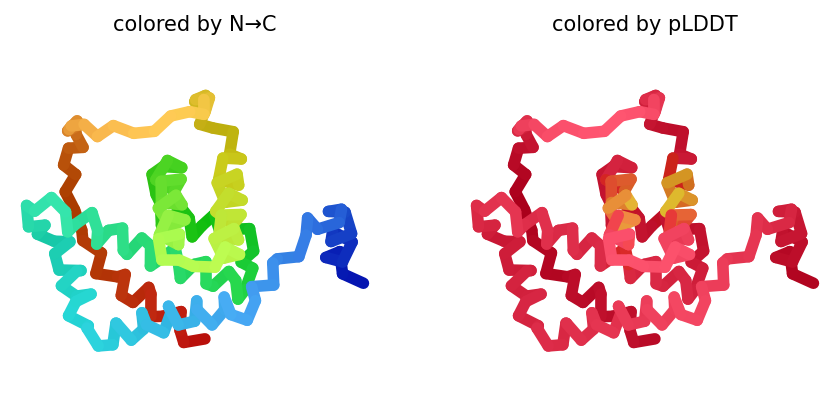

2023-09-15 06:21:28,160 reranking models by 'plddt' metric
2023-09-15 06:21:28,183 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=40.7 pTM=0.332
2023-09-15 06:21:32,562 Query 5/18: RKP13969.1 (length 240)


2023-09-15 06:21:33,260 Sleeping for 7s. Reason: PENDING


2023-09-15 06:21:40,940 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:21:51,626 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:22:00,564 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:22:06,505 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:22:14,118 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:22:21,858 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:22:28,438 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:03 remaining: 00:00]


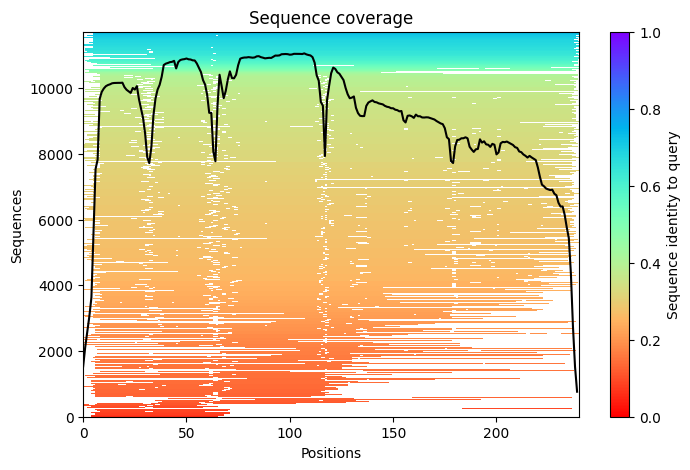

2023-09-15 06:22:53,998 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=82.2 pTM=0.811
2023-09-15 06:22:56,275 Padding length to 250
2023-09-15 06:23:03,376 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=81.6 pTM=0.808
2023-09-15 06:23:34,599 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.4 pTM=0.802 tol=0.885
2023-09-15 06:23:54,230 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=80.5 pTM=0.799 tol=0.509
2023-09-15 06:24:16,048 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=81.6 pTM=0.793 tol=0.324
2023-09-15 06:24:46,191 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=81.8 pTM=0.81 tol=0.114
2023-09-15 06:24:57,442 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=81.2 pTM=0.787 tol=0.449
2023-09-15 06:24:57,465 alphafold2_ptm_model_1_seed_000 took 260.4s (3 recycles)


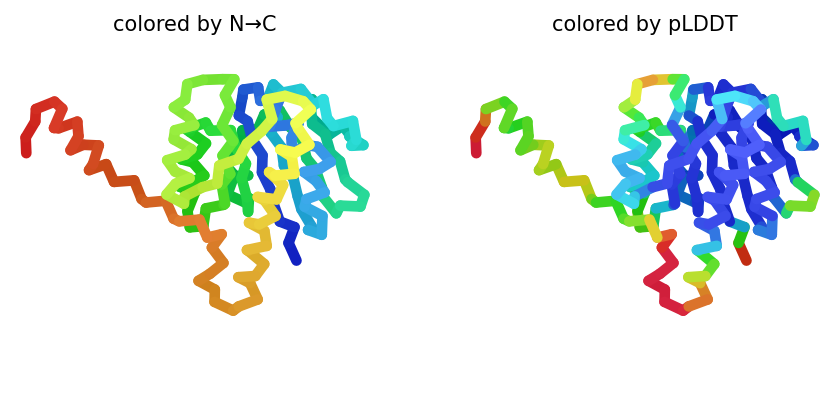

2023-09-15 06:24:58,264 reranking models by 'plddt' metric
2023-09-15 06:24:58,294 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=81.2 pTM=0.787
2023-09-15 06:25:00,991 Query 5/17: KAE8212004.1 (length 262)


2023-09-15 06:25:01,633 Sleeping for 9s. Reason: PENDING


2023-09-15 06:25:11,165 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:25:17,731 Sleeping for 8s. Reason: RUNNING


RUNNING:  10%|█         | 15/150 [elapsed: 00:16 remaining: 02:29]

2023-09-15 06:25:17,974 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=81.3 pTM=0.804 tol=0.0739
2023-09-15 06:25:17,985 alphafold2_ptm_model_1_seed_000 took 275.0s (3 recycles)


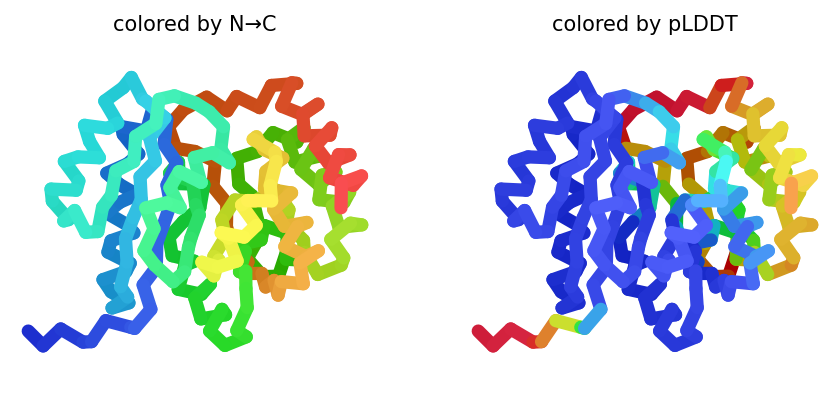

2023-09-15 06:25:18,494 reranking models by 'plddt' metric
2023-09-15 06:25:18,517 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=81.3 pTM=0.804
2023-09-15 06:25:21,271 Query 5/10: KDN36249.1 (length 263)


2023-09-15 06:25:21,858 Sleeping for 10s. Reason: PENDING


2023-09-15 06:25:26,341 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:25:32,486 Sleeping for 9s. Reason: RUNNING


2023-09-15 06:25:33,971 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:25:41,628 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:25:42,098 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:25:49,095 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:25:50,561 Sleeping for 9s. Reason: RUNNING


2023-09-15 06:25:55,568 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:39 remaining: 00:00]


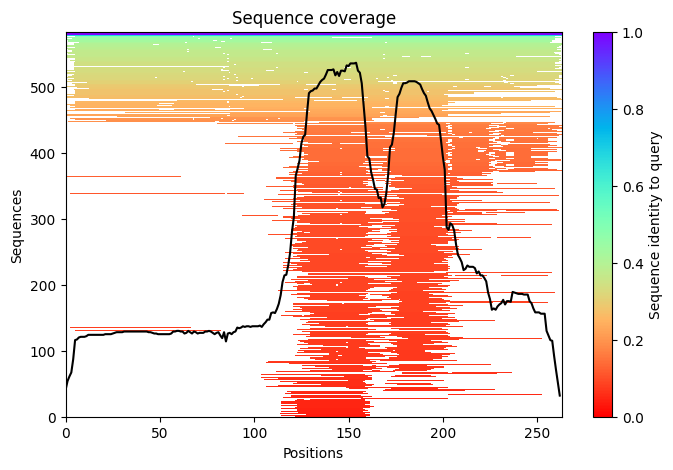

2023-09-15 06:26:02,065 Sleeping for 6s. Reason: RUNNING


RUNNING:  37%|███▋      | 56/150 [elapsed: 01:01 remaining: 01:41]

2023-09-15 06:26:03,038 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=86.8 pTM=0.849


2023-09-15 06:26:08,564 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:26:19,037 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:26:26,676 Sleeping for 10s. Reason: RUNNING


RUNNING:  53%|█████▎    | 79/150 [elapsed: 01:25 remaining: 01:16]

2023-09-15 06:26:27,238 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=85.9 pTM=0.844 tol=0.185


2023-09-15 06:26:37,135 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:26:47,593 Sleeping for 9s. Reason: RUNNING


RUNNING:  66%|██████▌   | 99/150 [elapsed: 01:46 remaining: 00:53]

2023-09-15 06:26:50,145 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=85.4 pTM=0.837 tol=0.109


2023-09-15 06:26:57,173 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:27:07,655 Sleeping for 10s. Reason: RUNNING


RUNNING:  79%|███████▊  | 118/150 [elapsed: 02:06 remaining: 00:33]

2023-09-15 06:27:12,916 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=86.3 pTM=0.844 tol=0.0906
2023-09-15 06:27:12,926 alphafold2_ptm_model_1_seed_000 took 256.6s (3 recycles)


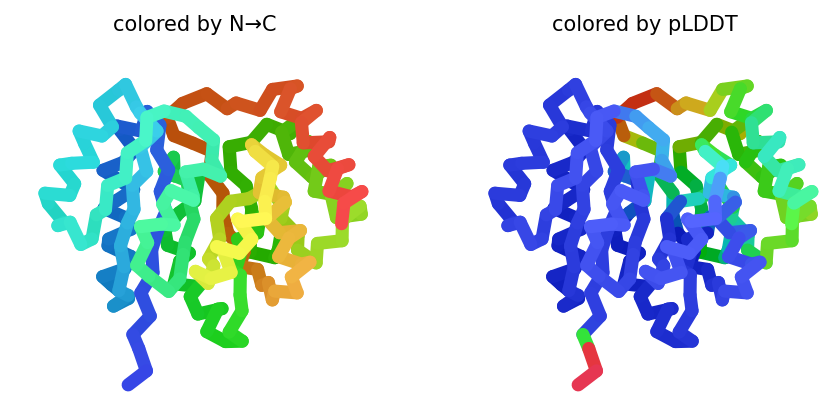

2023-09-15 06:27:13,560 reranking models by 'plddt' metric
2023-09-15 06:27:13,569 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=86.3 pTM=0.844
2023-09-15 06:27:15,630 Query 6/18: RKP12537.1 (length 245)


2023-09-15 06:27:16,113 Sleeping for 6s. Reason: PENDING


2023-09-15 06:27:18,101 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:27:22,523 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 02:24 remaining: 00:00]


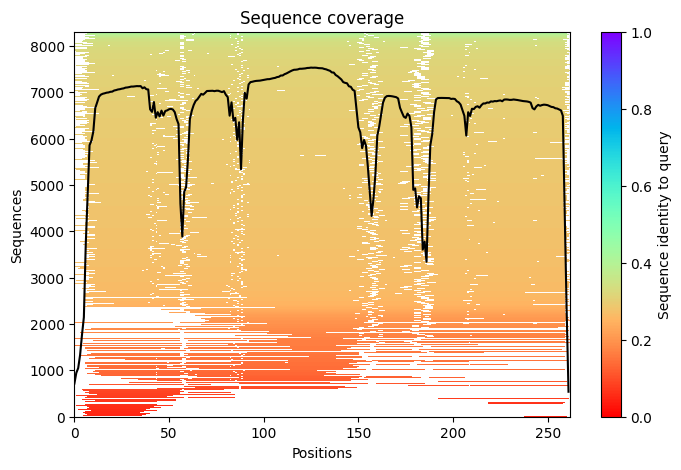

2023-09-15 06:27:33,091 Sleeping for 8s. Reason: RUNNING


RUNNING:  11%|█         | 16/150 [elapsed: 00:17 remaining: 02:25]

2023-09-15 06:27:34,449 Padding length to 272


2023-09-15 06:27:41,597 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:36 remaining: 00:00]


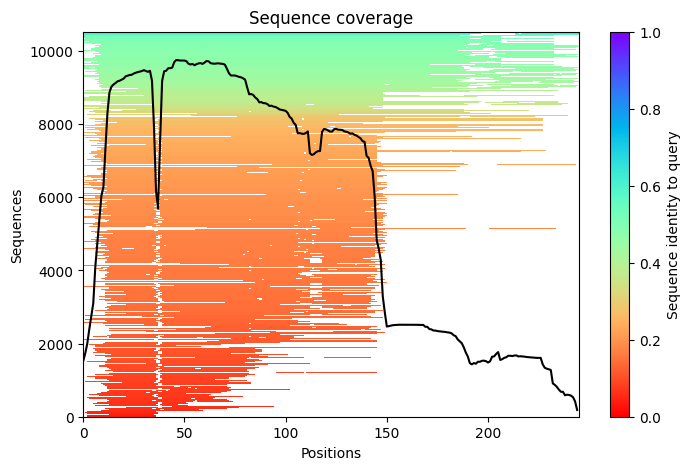

2023-09-15 06:28:07,893 Padding length to 250
2023-09-15 06:28:55,340 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=81.1 pTM=0.684
2023-09-15 06:29:06,457 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=93.5 pTM=0.913
2023-09-15 06:29:43,556 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.2 pTM=0.738 tol=4.29
2023-09-15 06:30:00,673 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=94.3 pTM=0.918 tol=0.253
2023-09-15 06:30:32,628 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=80.6 pTM=0.713 tol=0.362
2023-09-15 06:30:55,405 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=94.3 pTM=0.917 tol=0.138
2023-09-15 06:31:21,031 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=81 pTM=0.706 tol=0.342
2023-09-15 06:31:21,049 alphafold2_ptm_model_1_seed_000 took 193.1s (3 recycles)


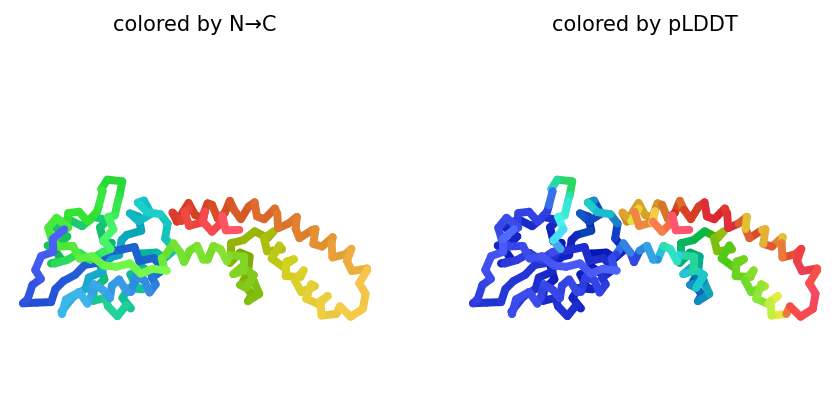

2023-09-15 06:31:21,564 reranking models by 'plddt' metric
2023-09-15 06:31:21,584 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=81 pTM=0.706
2023-09-15 06:31:23,520 Query 7/18: RKP12564.1 (length 285)


2023-09-15 06:31:23,983 Sleeping for 7s. Reason: PENDING


2023-09-15 06:31:31,449 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 7/150 [elapsed: 00:07 remaining: 02:41]

2023-09-15 06:31:34,592 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=94.4 pTM=0.918 tol=0.171
2023-09-15 06:31:34,595 alphafold2_ptm_model_1_seed_000 took 240.1s (3 recycles)


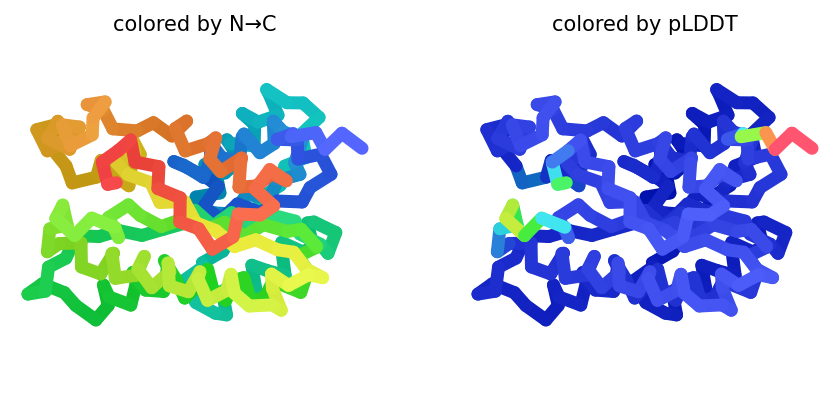

2023-09-15 06:31:34,972 reranking models by 'plddt' metric
2023-09-15 06:31:34,983 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=94.4 pTM=0.918
2023-09-15 06:31:36,317 Query 6/17: KAE8213736.1 (length 266)


2023-09-15 06:31:36,710 Sleeping for 8s. Reason: PENDING


2023-09-15 06:31:36,854 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:19 remaining: 00:00]


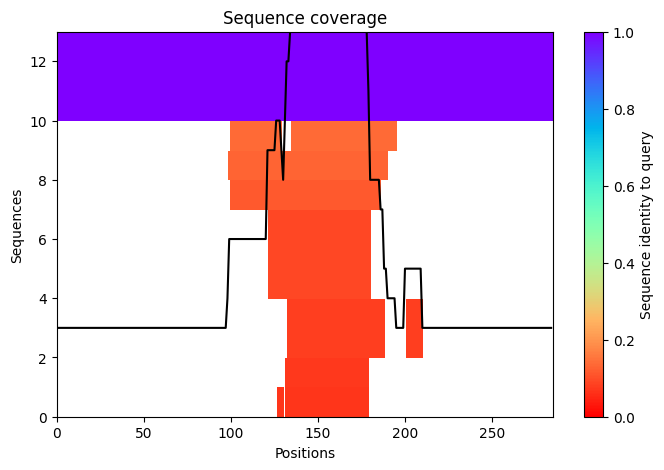

2023-09-15 06:31:44,995 Padding length to 295


2023-09-15 06:31:45,195 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:31:55,859 Sleeping for 9s. Reason: RUNNING


2023-09-15 06:32:05,348 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:32:11,179 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:45 remaining: 00:00]


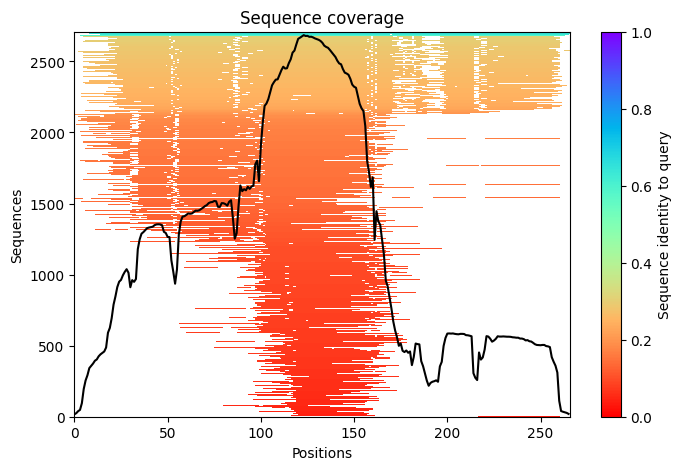

2023-09-15 06:32:26,527 Padding length to 272
2023-09-15 06:33:10,283 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=58.1 pTM=0.246
2023-09-15 06:33:21,125 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=83.6 pTM=0.827
2023-09-15 06:34:12,173 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=55.2 pTM=0.243 tol=7.85
2023-09-15 06:34:15,234 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=85.5 pTM=0.845 tol=2.41
2023-09-15 06:35:09,617 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=85.9 pTM=0.848 tol=2.21
2023-09-15 06:35:13,646 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=55 pTM=0.237 tol=5.03
2023-09-15 06:36:03,531 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=86.9 pTM=0.853 tol=0.395
2023-09-15 06:36:03,548 alphafold2_ptm_model_1_seed_000 took 217.0s (3 recycles)


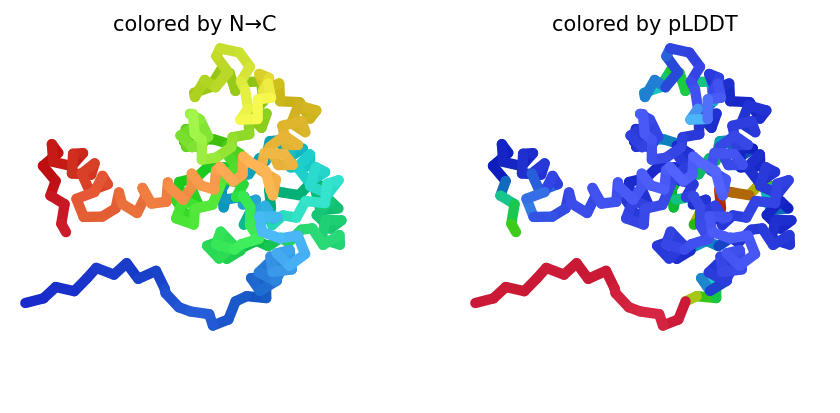

2023-09-15 06:36:04,125 reranking models by 'plddt' metric
2023-09-15 06:36:04,152 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=86.9 pTM=0.853
2023-09-15 06:36:07,018 Query 7/17: KAE8213549.1 (length 279)


2023-09-15 06:36:07,609 Sleeping for 9s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 06:36:09,244 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=55.9 pTM=0.245 tol=4.31
2023-09-15 06:36:09,255 alphafold2_ptm_model_1_seed_000 took 264.3s (3 recycles)


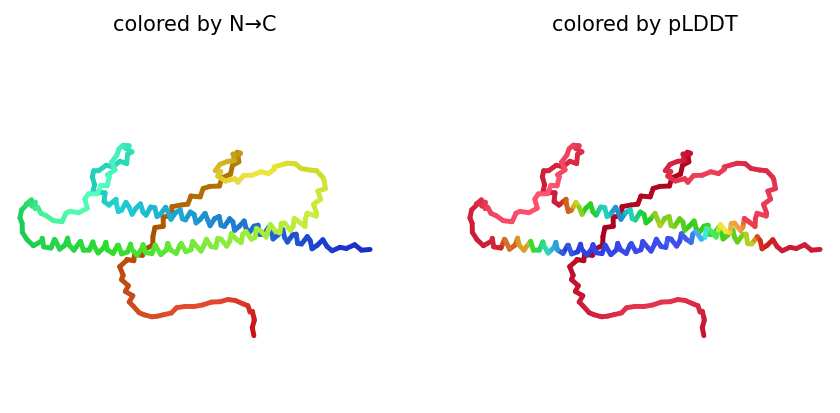

2023-09-15 06:36:09,860 reranking models by 'plddt' metric
2023-09-15 06:36:09,870 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=55.9 pTM=0.245
2023-09-15 06:36:11,590 Query 8/18: RKP12434.1 (length 288)



2023-09-15 06:36:11,956 Sleeping for 5s. Reason: PENDING

2023-09-15 06:36:17,006 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:36:17,397 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:36:22,453 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:36:23,842 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:36:29,843 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:36:34,259 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:36:38,355 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:36:40,820 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:36:44,774 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:36:47,257 Sleeping for 9s. Reason: RUNNING


2023-09-15 06:36:50,268 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:36:56,687 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:37:00,656 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:37:06,120 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:56 remaining: 00:00]


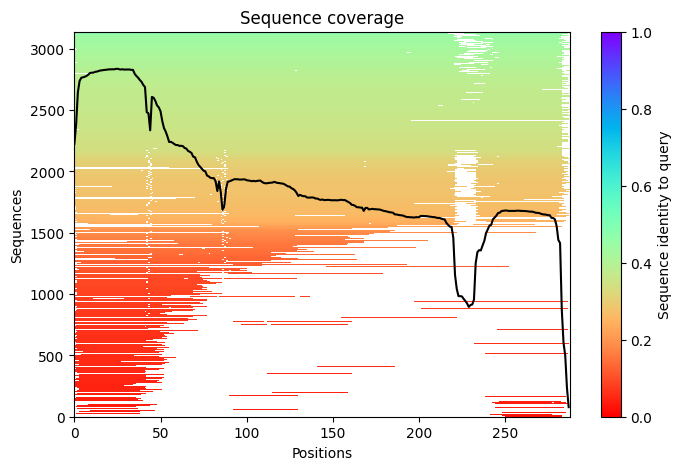

2023-09-15 06:37:11,578 Padding length to 295


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:07 remaining: 00:00]


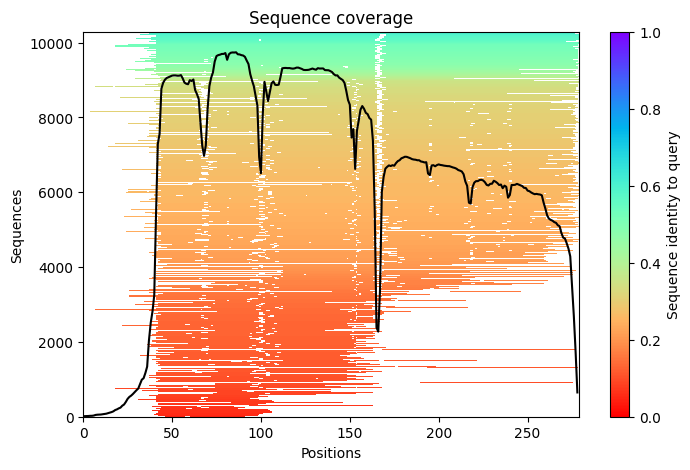

2023-09-15 06:37:28,483 Padding length to 289
2023-09-15 06:37:42,079 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=86.8 pTM=0.836
2023-09-15 06:38:14,594 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=88.1 pTM=0.85 tol=0.539
2023-09-15 06:38:46,883 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=88.7 pTM=0.858 tol=0.174
2023-09-15 06:39:19,670 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=89.1 pTM=0.86 tol=0.0609
2023-09-15 06:39:19,687 alphafold2_ptm_model_1_seed_000 took 128.1s (3 recycles)


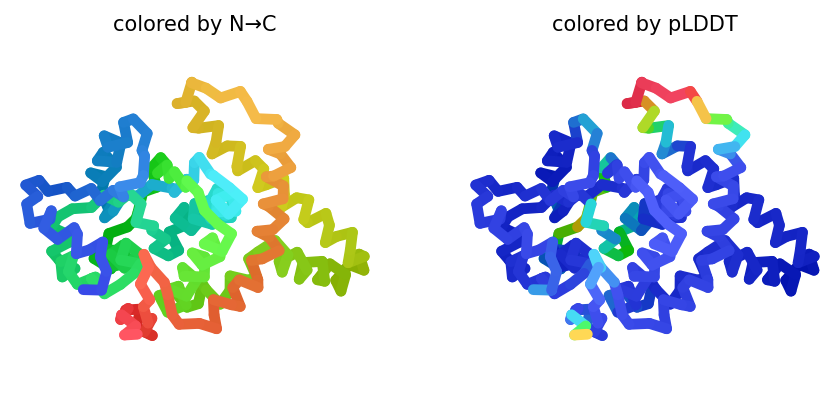

2023-09-15 06:39:20,392 reranking models by 'plddt' metric
2023-09-15 06:39:20,418 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=89.1 pTM=0.86
2023-09-15 06:39:22,344 Query 9/18: RKP11517.1 (length 292)


2023-09-15 06:39:22,884 Sleeping for 5s. Reason: PENDING


2023-09-15 06:39:28,526 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:39:36,203 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:25 remaining: 00:00]


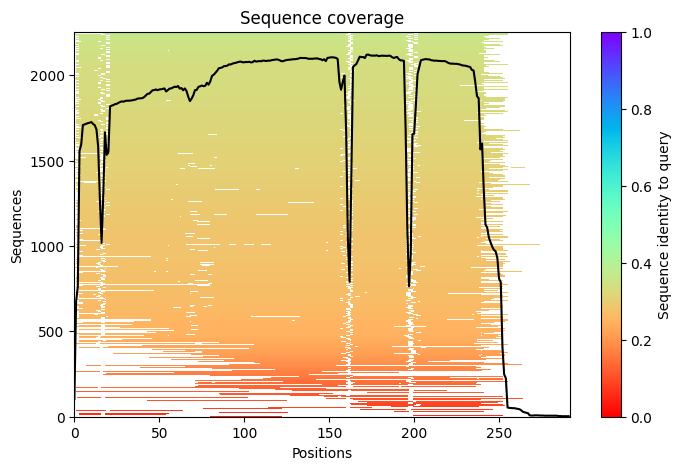

2023-09-15 06:39:53,357 Padding length to 295
2023-09-15 06:40:26,902 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76 pTM=0.73
2023-09-15 06:40:56,991 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=77.8 pTM=0.665
2023-09-15 06:41:28,498 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=76.1 pTM=0.739 tol=2.17
2023-09-15 06:42:00,256 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=78.8 pTM=0.682 tol=2.15
2023-09-15 06:42:30,402 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=75.5 pTM=0.728 tol=2.73
2023-09-15 06:43:03,408 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=79.2 pTM=0.69 tol=0.94
2023-09-15 06:43:32,156 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76 pTM=0.734 tol=3.6
2023-09-15 06:43:32,170 alphafold2_ptm_model_1_seed_000 took 363.7s (3 recycles)


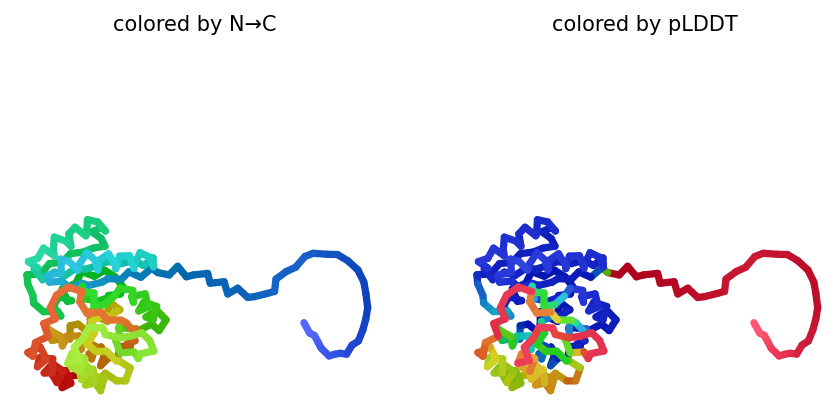

2023-09-15 06:43:32,777 reranking models by 'plddt' metric
2023-09-15 06:43:32,790 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76 pTM=0.734
2023-09-15 06:43:34,824 Query 8/17: KAE8216036.1 (length 417)


2023-09-15 06:43:35,527 Sleeping for 10s. Reason: PENDING


2023-09-15 06:43:45,983 Sleeping for 9s. Reason: RUNNING


RUNNING:   7%|▋         | 10/150 [elapsed: 00:11 remaining: 02:35]

2023-09-15 06:43:48,249 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=79.1 pTM=0.688 tol=0.636
2023-09-15 06:43:48,267 alphafold2_ptm_model_1_seed_000 took 234.9s (3 recycles)


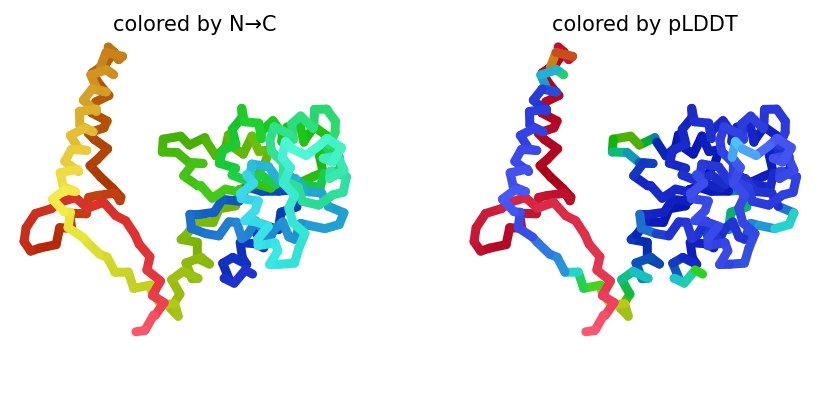

2023-09-15 06:43:48,659 reranking models by 'plddt' metric
2023-09-15 06:43:48,662 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=79.1 pTM=0.688
2023-09-15 06:43:49,918 Query 10/18: RKP13210.1 (length 328)


2023-09-15 06:43:50,339 Sleeping for 10s. Reason: PENDING


2023-09-15 06:43:55,511 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:44:00,711 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:44:02,135 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:44:08,152 Sleeping for 5s. Reason: RUNNING


2023-09-15 06:44:08,666 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:44:13,572 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:44:17,063 Sleeping for 7s. Reason: RUNNING


2023-09-15 06:44:24,595 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:34 remaining: 00:00]


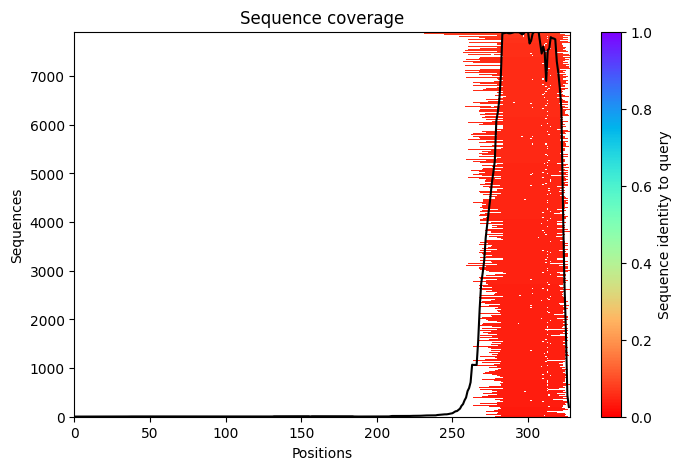

2023-09-15 06:44:33,064 Padding length to 338


2023-09-15 06:44:34,089 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:44:44,616 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:17 remaining: 00:00]


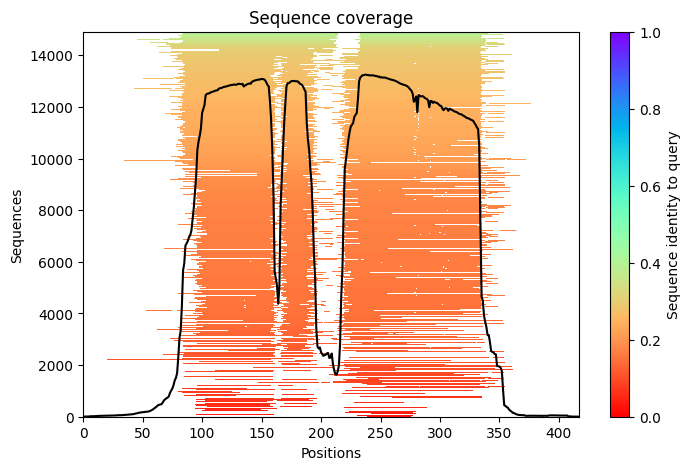

2023-09-15 06:45:23,059 Padding length to 427
2023-09-15 06:46:04,514 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=48.8 pTM=0.372
2023-09-15 06:46:45,221 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=48.3 pTM=0.363 tol=12.6
2023-09-15 06:47:26,482 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=50.2 pTM=0.39 tol=5.73
2023-09-15 06:48:07,708 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=54.9 pTM=0.428 tol=6.07
2023-09-15 06:48:07,724 alphafold2_ptm_model_1_seed_000 took 214.7s (3 recycles)


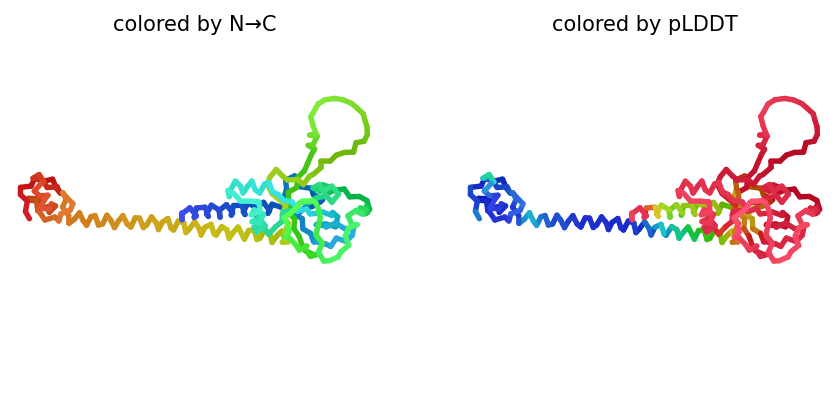

2023-09-15 06:48:08,874 reranking models by 'plddt' metric
2023-09-15 06:48:08,904 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=54.9 pTM=0.428
2023-09-15 06:48:12,803 Query 11/18: RKP11265.1 (length 400)


2023-09-15 06:48:13,386 Sleeping for 8s. Reason: PENDING


2023-09-15 06:48:21,870 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:48:32,378 Sleeping for 6s. Reason: RUNNING


2023-09-15 06:48:38,842 Sleeping for 8s. Reason: RUNNING


2023-09-15 06:48:47,292 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:46 remaining: 00:00]


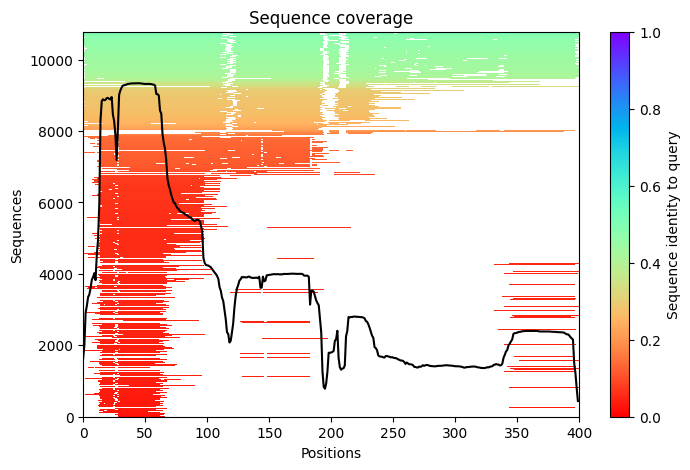

2023-09-15 06:49:15,705 Padding length to 410
2023-09-15 06:49:28,952 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.6 pTM=0.684
2023-09-15 06:50:29,606 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=70.3 pTM=0.697 tol=2.62
2023-09-15 06:51:31,059 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.4 pTM=0.7 tol=2.91
2023-09-15 06:52:32,237 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=71.6 pTM=0.703 tol=3.53
2023-09-15 06:52:32,251 alphafold2_ptm_model_1_seed_000 took 429.2s (3 recycles)


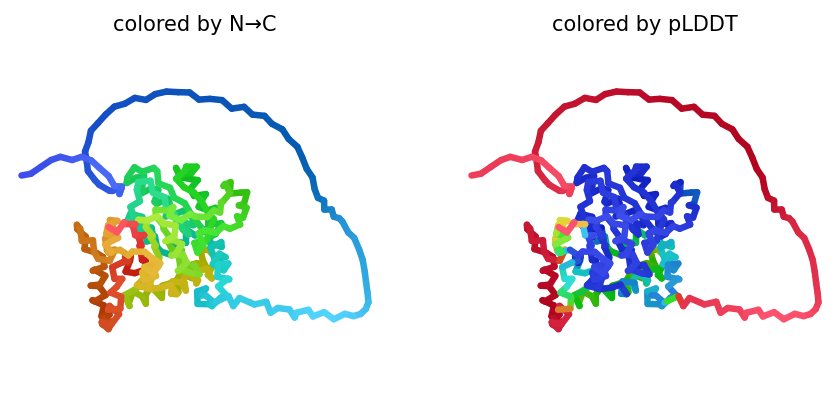

2023-09-15 06:52:33,211 reranking models by 'plddt' metric
2023-09-15 06:52:33,224 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=71.6 pTM=0.703
2023-09-15 06:52:37,034 Query 9/17: KAE8209681.1 (length 426)


2023-09-15 06:52:37,539 Sleeping for 10s. Reason: PENDING


2023-09-15 06:52:48,068 Sleeping for 10s. Reason: RUNNING


2023-09-15 06:52:58,678 Sleeping for 9s. Reason: RUNNING


2023-09-15 06:53:08,125 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:40 remaining: 00:00]


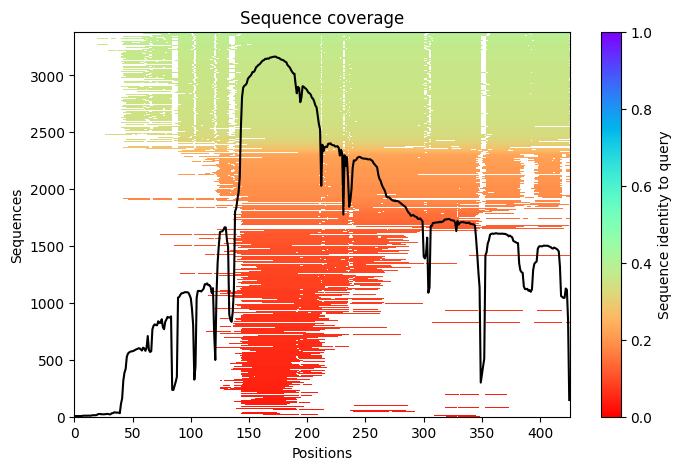

2023-09-15 06:53:24,891 Padding length to 427
2023-09-15 06:54:10,894 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=64.9 pTM=0.453
2023-09-15 06:55:23,606 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=81.5 pTM=0.78
2023-09-15 06:56:01,241 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=65.6 pTM=0.474 tol=6.35
2023-09-15 06:57:21,740 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=81.9 pTM=0.778 tol=2.92
2023-09-15 06:57:52,200 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66 pTM=0.471 tol=5.14
2023-09-15 06:59:20,107 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=80.4 pTM=0.76 tol=3.37
2023-09-15 06:59:43,471 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.2 pTM=0.477 tol=2.4
2023-09-15 06:59:43,488 alphafold2_ptm_model_1_seed_000 took 627.8s (3 recycles)


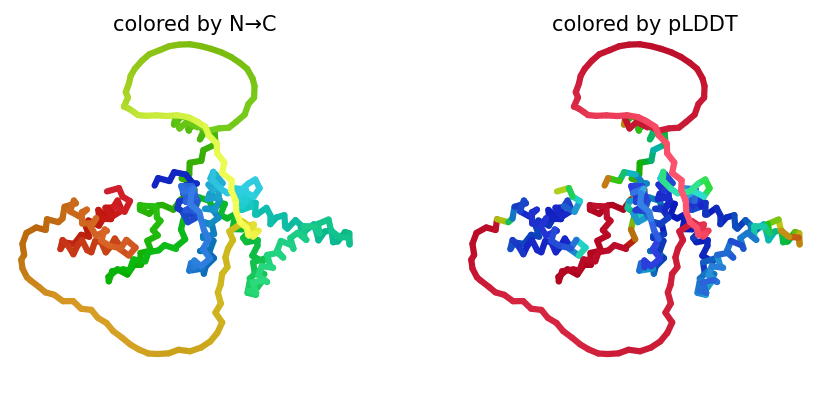

2023-09-15 06:59:44,890 reranking models by 'plddt' metric
2023-09-15 06:59:44,903 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.2 pTM=0.477
2023-09-15 06:59:49,332 Query 12/18: RKP11485.1 (length 413)


2023-09-15 06:59:49,909 Sleeping for 9s. Reason: PENDING


2023-09-15 06:59:59,381 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:00:07,822 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:00:14,408 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:00:19,997 Sleeping for 8s. Reason: RUNNING


RUNNING:  19%|█▊        | 28/150 [elapsed: 00:30 remaining: 02:13]

2023-09-15 07:00:27,696 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=80.2 pTM=0.757 tol=0.667
2023-09-15 07:00:27,699 alphafold2_ptm_model_1_seed_000 took 422.8s (3 recycles)


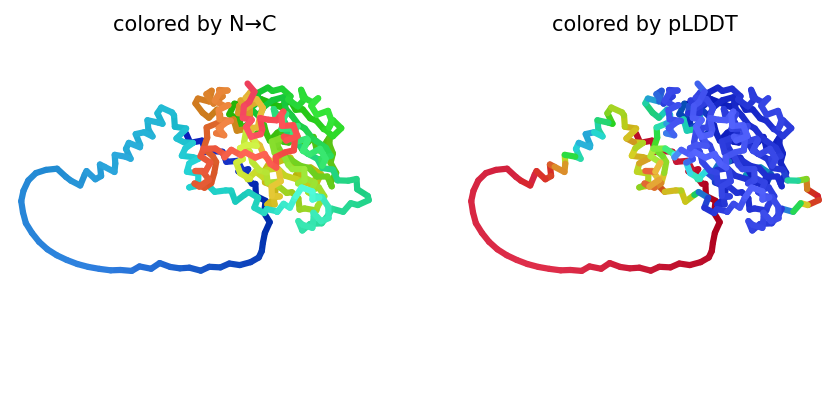

2023-09-15 07:00:28,322 reranking models by 'plddt' metric
2023-09-15 07:00:28,327 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=80.2 pTM=0.757


2023-09-15 07:00:28,489 Sleeping for 6s. Reason: RUNNING


RUNNING:  24%|██▍       | 36/150 [elapsed: 00:39 remaining: 02:03]

2023-09-15 07:00:29,873 Query 10/17: KAE8213379.1 (length 441)


2023-09-15 07:00:30,347 Sleeping for 9s. Reason: PENDING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:46 remaining: 00:00]


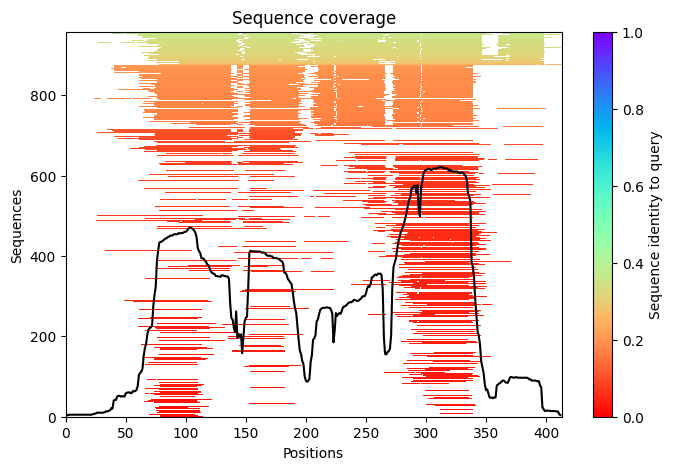

2023-09-15 07:00:38,382 Padding length to 423


2023-09-15 07:00:39,795 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:00:50,388 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:00:57,921 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:01:05,560 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:01:14,037 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:01:21,616 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:01:29,094 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:01:39,680 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:01:46,139 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:01:53,691 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:02:02,145 Sleeping for 10s. Reason: RUNNING


RUNNING:  57%|█████▋    | 86/150 [elapsed: 01:32 remaining: 01:08]

2023-09-15 07:02:08,000 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=72.5 pTM=0.773


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:43 remaining: 00:00]


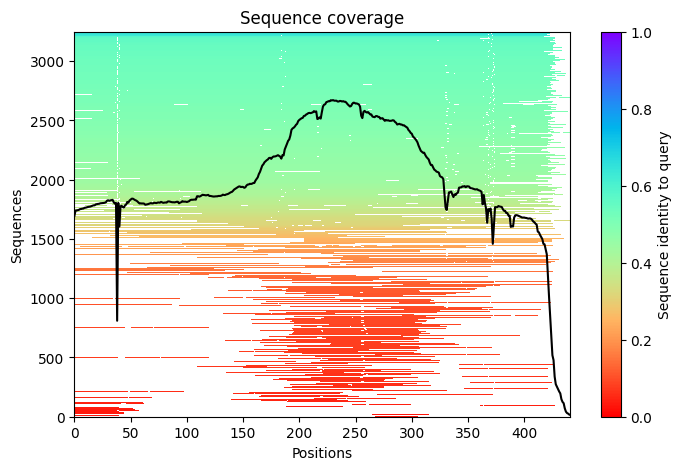

2023-09-15 07:02:23,999 Padding length to 451
2023-09-15 07:03:04,501 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=75.2 pTM=0.802 tol=3.28
2023-09-15 07:04:04,349 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=76.3 pTM=0.81 tol=0.944
2023-09-15 07:05:04,259 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.9 pTM=0.803 tol=0.86
2023-09-15 07:05:04,267 alphafold2_ptm_model_1_seed_000 took 265.9s (3 recycles)


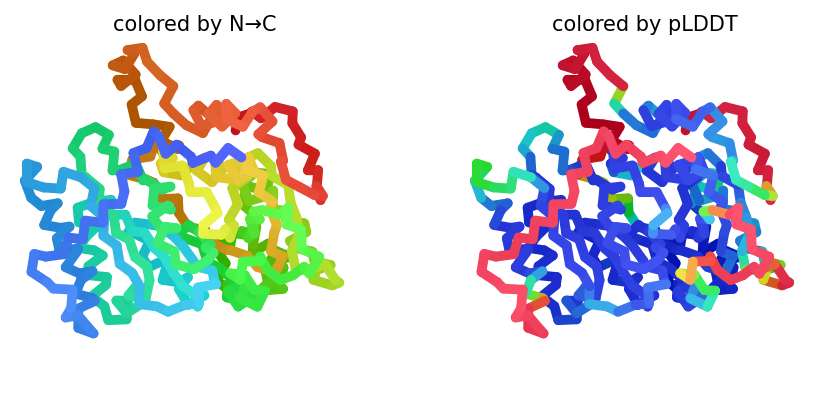

2023-09-15 07:05:05,247 reranking models by 'plddt' metric
2023-09-15 07:05:05,269 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.9 pTM=0.803
2023-09-15 07:05:07,402 Query 13/18: RKP12248.1 (length 427)


2023-09-15 07:05:07,911 Sleeping for 5s. Reason: PENDING


2023-09-15 07:05:13,412 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:05:22,961 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:05:29,508 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:05:36,951 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:05:43,411 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:42 remaining: 00:00]


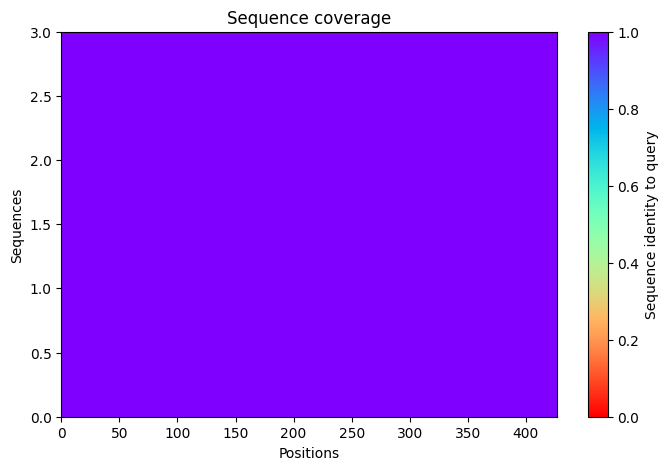

2023-09-15 07:05:53,247 Padding length to 437
2023-09-15 07:06:31,301 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=88.2 pTM=0.835
2023-09-15 07:07:40,092 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=88.8 pTM=0.851 tol=0.886
2023-09-15 07:08:48,415 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=89.3 pTM=0.856 tol=0.327
2023-09-15 07:09:56,679 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=89.6 pTM=0.86 tol=0.191
2023-09-15 07:09:56,695 alphafold2_ptm_model_1_seed_000 took 452.7s (3 recycles)


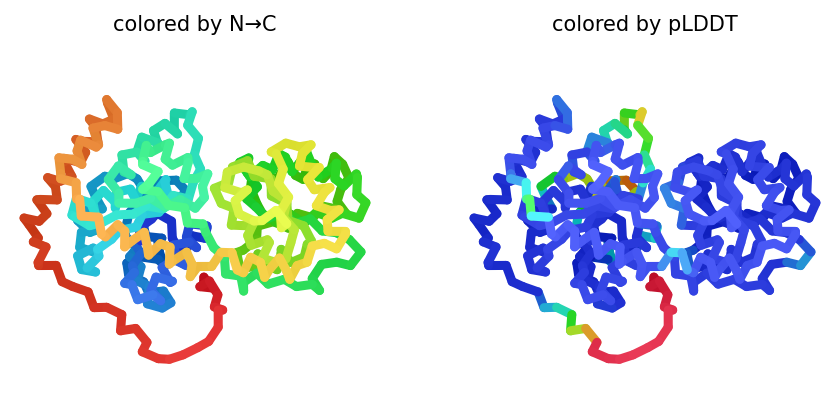

2023-09-15 07:09:57,792 reranking models by 'plddt' metric
2023-09-15 07:09:57,806 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=89.6 pTM=0.86
2023-09-15 07:10:01,622 Query 11/17: KAE8211755.1 (length 461)


2023-09-15 07:10:02,222 Sleeping for 10s. Reason: PENDING


2023-09-15 07:10:12,791 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:18 remaining: 00:00]


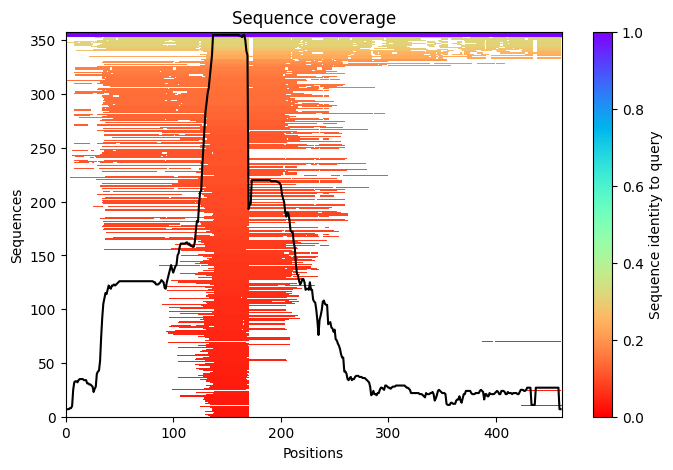

2023-09-15 07:10:34,776 Padding length to 471
2023-09-15 07:11:17,091 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=44.7 pTM=0.255
2023-09-15 07:12:18,557 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=40 pTM=0.253 tol=8.8
2023-09-15 07:13:20,388 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=40 pTM=0.253 tol=2.61
2023-09-15 07:14:21,992 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=39.7 pTM=0.255 tol=2.47
2023-09-15 07:14:22,009 alphafold2_ptm_model_1_seed_000 took 508.8s (3 recycles)


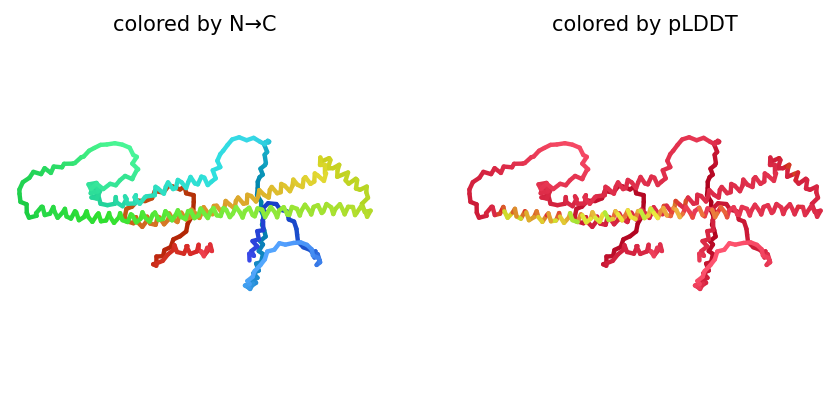

2023-09-15 07:14:22,977 reranking models by 'plddt' metric
2023-09-15 07:14:22,999 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=39.7 pTM=0.255
2023-09-15 07:14:24,982 Query 14/18: RKP12401.1 (length 431)


2023-09-15 07:14:25,558 Sleeping for 6s. Reason: PENDING


2023-09-15 07:14:32,171 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:14:40,714 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:14:50,399 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:14:58,872 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:15:07,441 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:15:17,889 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:15:25,408 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:11 remaining: 00:00]


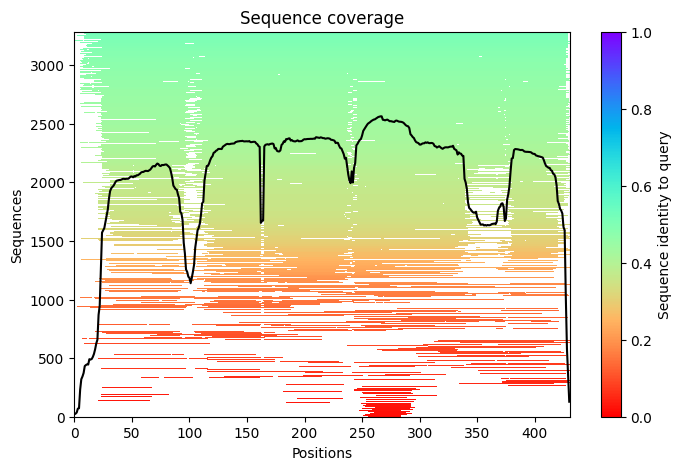

2023-09-15 07:15:46,250 Padding length to 437
2023-09-15 07:15:54,330 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=44.4 pTM=0.235
2023-09-15 07:17:48,492 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=89.2 pTM=0.89
2023-09-15 07:18:14,386 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=43.3 pTM=0.243 tol=15.1
2023-09-15 07:19:51,342 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=91 pTM=0.906 tol=0.431
2023-09-15 07:20:33,725 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=43.6 pTM=0.236 tol=15.7
2023-09-15 07:21:54,070 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=90.9 pTM=0.902 tol=0.118
2023-09-15 07:22:53,847 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=42.8 pTM=0.235 tol=12.1
2023-09-15 07:22:53,860 alphafold2_ptm_model_1_seed_000 took 739.1s (3 recycles)


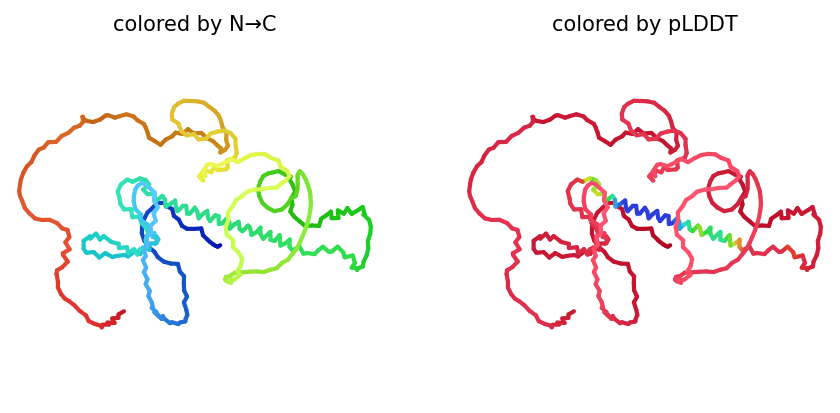

2023-09-15 07:22:54,903 reranking models by 'plddt' metric
2023-09-15 07:22:54,922 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=42.8 pTM=0.235
2023-09-15 07:22:56,837 Query 12/17: KAE8215048.1 (length 464)


2023-09-15 07:22:57,352 Sleeping for 6s. Reason: PENDING


2023-09-15 07:23:03,948 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:23:13,435 Sleeping for 10s. Reason: RUNNING


RUNNING:  10%|█         | 15/150 [elapsed: 00:16 remaining: 02:27]

2023-09-15 07:23:23,366 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=91.3 pTM=0.906 tol=0.0898
2023-09-15 07:23:23,372 alphafold2_ptm_model_1_seed_000 took 457.1s (3 recycles)


2023-09-15 07:23:23,907 Sleeping for 9s. Reason: RUNNING


RUNNING:  17%|█▋        | 25/150 [elapsed: 00:27 remaining: 02:13]

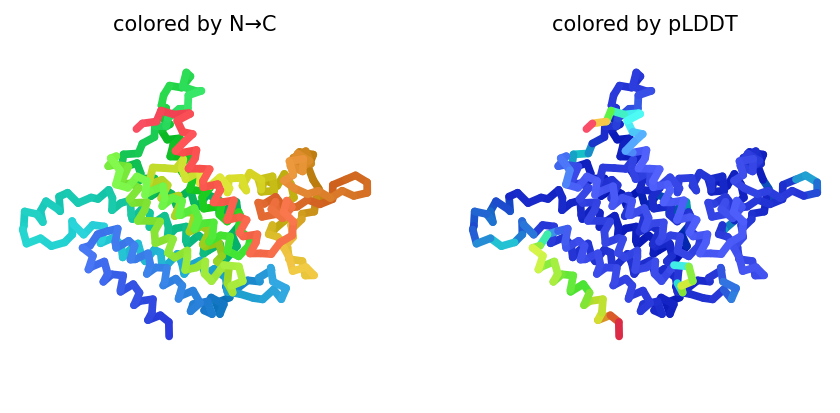

2023-09-15 07:23:24,371 reranking models by 'plddt' metric
2023-09-15 07:23:24,377 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=91.3 pTM=0.906
2023-09-15 07:23:25,763 Query 15/18: RKP12063.1 (length 444)


2023-09-15 07:23:26,186 Sleeping for 9s. Reason: PENDING


2023-09-15 07:23:33,311 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:23:35,610 Sleeping for 9s. Reason: RUNNING


RUNNING:  23%|██▎       | 34/150 [elapsed: 00:46 remaining: 02:02]

2023-09-15 07:23:43,709 Sleeping for 9s. Reason: RUNNING

2023-09-15 07:23:44,993 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:23:53,094 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:29 remaining: 00:00]


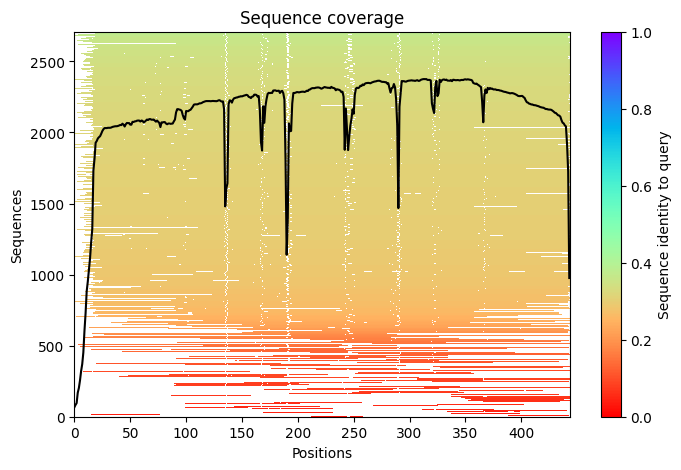

2023-09-15 07:24:00,657 Sleeping for 8s. Reason: RUNNING


RUNNING:  40%|████      | 60/150 [elapsed: 01:03 remaining: 01:35]

2023-09-15 07:24:01,745 Padding length to 454


2023-09-15 07:24:09,157 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:19 remaining: 00:00]


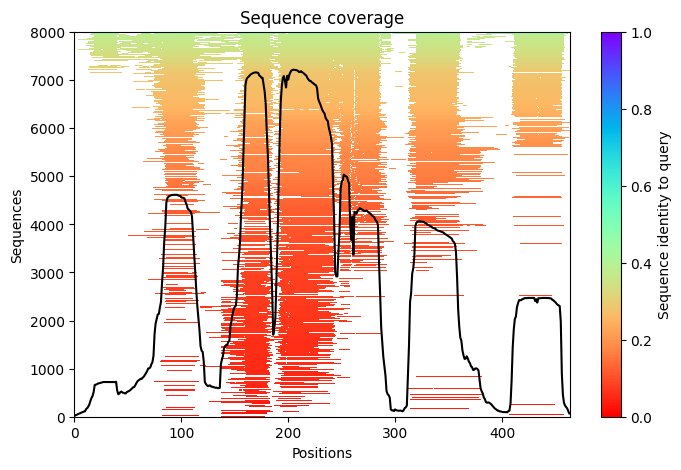

2023-09-15 07:24:37,016 Padding length to 471
2023-09-15 07:26:45,454 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73.8 pTM=0.772
2023-09-15 07:27:04,811 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=80.4 pTM=0.72
2023-09-15 07:29:07,733 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=77.2 pTM=0.803 tol=2.54
2023-09-15 07:29:17,210 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.8 pTM=0.743 tol=1.7
2023-09-15 07:31:29,915 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=78 pTM=0.812 tol=0.557
2023-09-15 07:31:30,813 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=82.2 pTM=0.746 tol=0.398
2023-09-15 07:33:45,104 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=83.6 pTM=0.754 tol=0.514
2023-09-15 07:33:45,118 alphafold2_ptm_model_1_seed_000 took 583.4s (3 recycles)


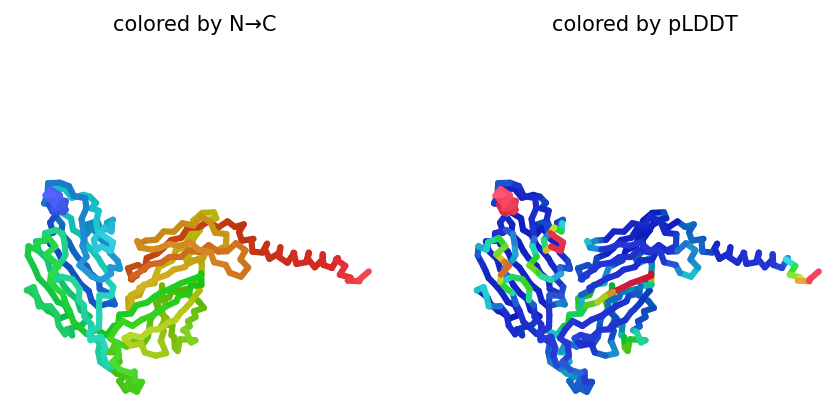

2023-09-15 07:33:46,151 reranking models by 'plddt' metric
2023-09-15 07:33:46,163 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=83.6 pTM=0.754
2023-09-15 07:33:47,939 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=78.2 pTM=0.811 tol=0.469
2023-09-15 07:33:47,957 alphafold2_ptm_model_1_seed_000 took 550.9s (3 recycles)


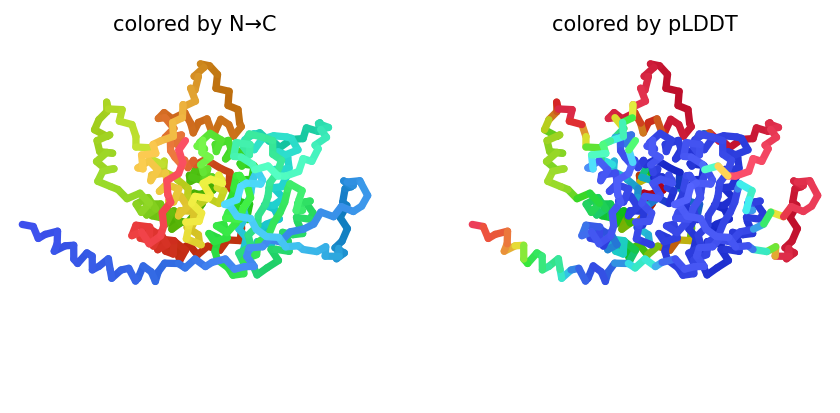

2023-09-15 07:33:48,481 Query 16/18: RKP13505.1 (length 472)


SUBMIT:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 07:33:48,992 reranking models by 'plddt' metric
2023-09-15 07:33:48,998 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=78.2 pTM=0.811


2023-09-15 07:33:49,083 Sleeping for 8s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-09-15 07:33:50,715 Query 13/17: KAE8214445.1 (length 470)


2023-09-15 07:33:51,133 Sleeping for 10s. Reason: PENDING


2023-09-15 07:33:57,495 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:34:01,548 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:34:05,940 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:34:11,982 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:34:16,323 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:34:19,371 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:34:23,780 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:34:28,740 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:34:30,153 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:34:36,586 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:34:38,120 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:34:42,956 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:34:43,515 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:58 remaining: 00:00]


2023-09-15 07:34:50,580 Sleeping for 7s. Reason: RUNNING


RUNNING:  39%|███▊      | 58/150 [elapsed: 01:02 remaining: 01:38]

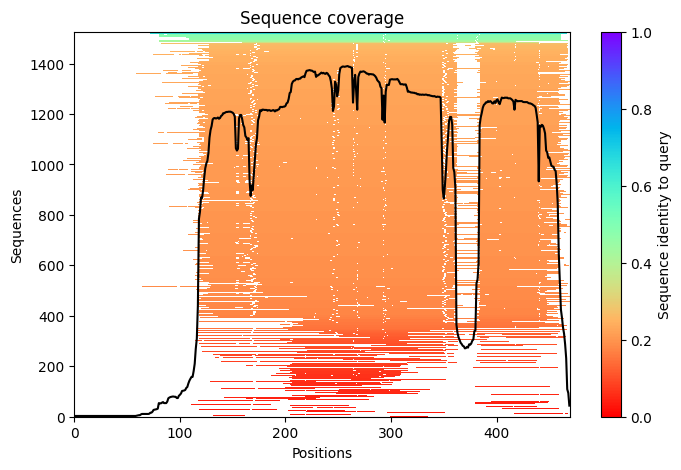

2023-09-15 07:34:55,792 Padding length to 471


2023-09-15 07:34:58,095 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:16 remaining: 00:00]


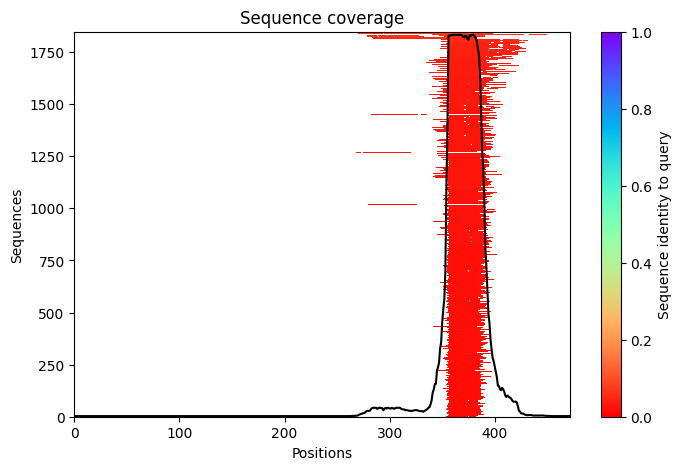

2023-09-15 07:35:14,800 Padding length to 482
2023-09-15 07:36:05,985 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=71.3 pTM=0.728
2023-09-15 07:37:19,375 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=72.7 pTM=0.756 tol=8.99
2023-09-15 07:38:32,347 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=72.1 pTM=0.741 tol=5.42
2023-09-15 07:39:45,022 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=73.4 pTM=0.76 tol=7.77
2023-09-15 07:39:45,039 alphafold2_ptm_model_1_seed_000 took 289.2s (3 recycles)


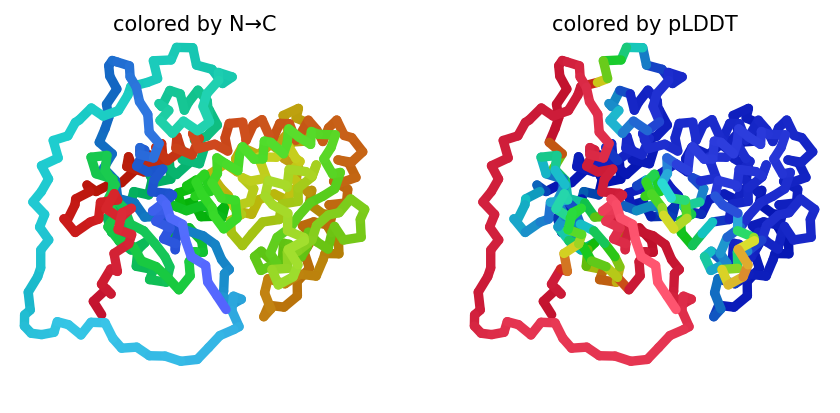

2023-09-15 07:39:46,076 reranking models by 'plddt' metric
2023-09-15 07:39:46,093 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=73.4 pTM=0.76
2023-09-15 07:39:48,304 Query 14/17: KAE8210184.1 (length 481)


2023-09-15 07:39:48,889 Sleeping for 5s. Reason: PENDING


2023-09-15 07:39:54,494 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:40:02,129 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:40:11,617 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:40:22,098 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:40:30,683 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:40:41,163 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:40:47,830 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:40:57,306 Sleeping for 9s. Reason: RUNNING


2023-09-15 07:41:06,875 Sleeping for 9s. Reason: RUNNING


RUNNING:  49%|████▊     | 73/150 [elapsed: 01:18 remaining: 01:22]

2023-09-15 07:41:16,381 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=40.1 pTM=0.242


2023-09-15 07:41:16,476 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:41:24,915 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:41:31,488 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:52 remaining: 00:00]


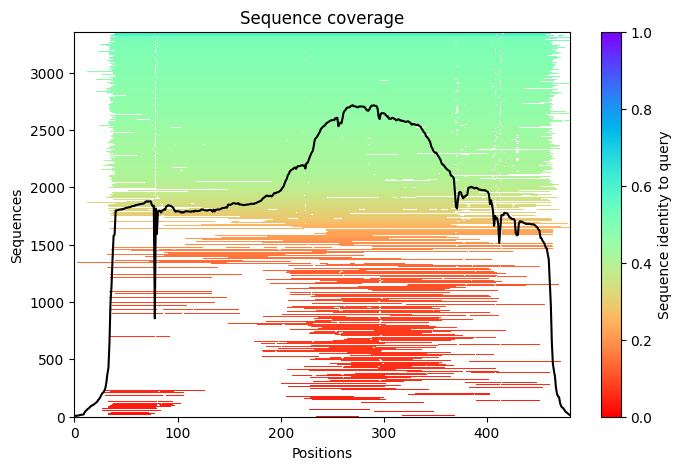

2023-09-15 07:41:51,893 Padding length to 491
2023-09-15 07:42:26,479 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=40.1 pTM=0.239 tol=10.7
2023-09-15 07:43:42,610 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=40.7 pTM=0.239 tol=6.08
2023-09-15 07:44:58,412 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=43.4 pTM=0.244 tol=5.62
2023-09-15 07:44:58,431 alphafold2_ptm_model_1_seed_000 took 583.6s (3 recycles)


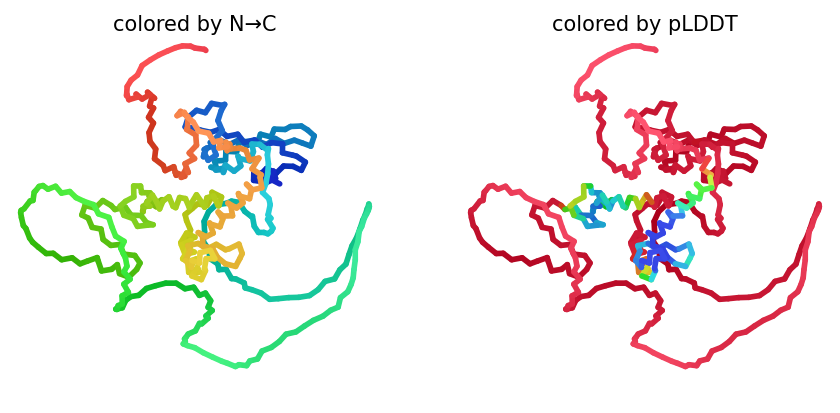

2023-09-15 07:44:59,567 reranking models by 'plddt' metric
2023-09-15 07:44:59,582 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=43.4 pTM=0.244
2023-09-15 07:45:03,392 Query 17/18: RKP13990.1 (length 479)


2023-09-15 07:45:03,996 Sleeping for 5s. Reason: PENDING


2023-09-15 07:45:09,458 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:45:20,121 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:45:25,600 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:45:32,061 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:45:37,532 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:45:46,019 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:45:52,600 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:45:59,049 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:46:09,612 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:16 remaining: 00:00]


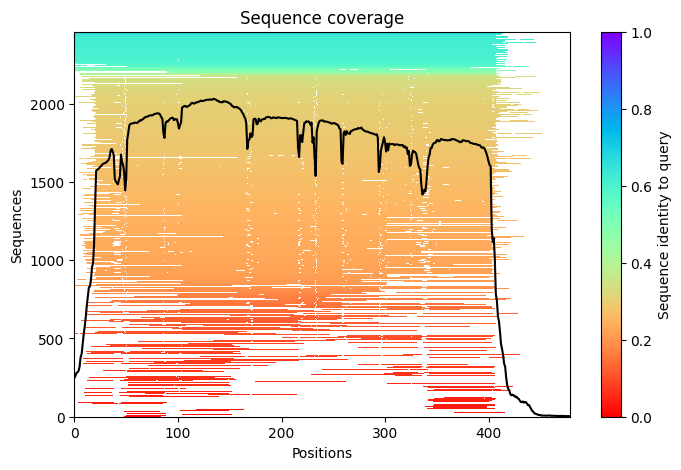

2023-09-15 07:46:32,270 Padding length to 482
2023-09-15 07:46:41,369 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=85.1 pTM=0.807
2023-09-15 07:48:58,579 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=81.4 pTM=0.785
2023-09-15 07:49:13,105 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=84.9 pTM=0.817 tol=2.09
2023-09-15 07:51:26,694 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=81.8 pTM=0.793 tol=4.22
2023-09-15 07:51:44,175 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=85.4 pTM=0.82 tol=0.803
2023-09-15 07:53:53,732 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=81.6 pTM=0.791 tol=3.61
2023-09-15 07:54:15,544 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=85.6 pTM=0.821 tol=0.726
2023-09-15 07:54:15,565 alphafold2_ptm_model_1_seed_000 took 743.7s (3 recycles)


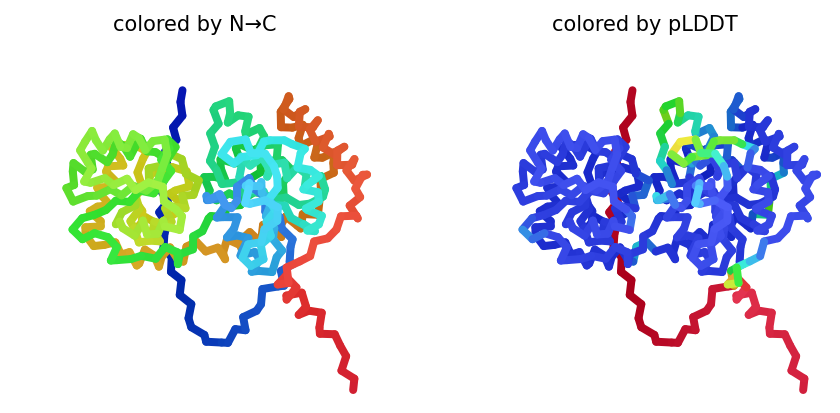

2023-09-15 07:54:16,593 reranking models by 'plddt' metric
2023-09-15 07:54:16,612 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=85.6 pTM=0.821
2023-09-15 07:54:20,381 Query 15/17: KAE8212966.1 (length 481)


2023-09-15 07:54:21,000 Sleeping for 6s. Reason: PENDING


2023-09-15 07:54:27,470 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:54:35,130 Sleeping for 7s. Reason: RUNNING


2023-09-15 07:54:42,616 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:54:49,078 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:54:54,745 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:55:00,187 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:55:05,639 Sleeping for 10s. Reason: RUNNING


RUNNING:  27%|██▋       | 41/150 [elapsed: 00:45 remaining: 01:59]

2023-09-15 07:55:13,350 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=81.8 pTM=0.791 tol=1.55
2023-09-15 07:55:13,359 alphafold2_ptm_model_1_seed_000 took 521.1s (3 recycles)


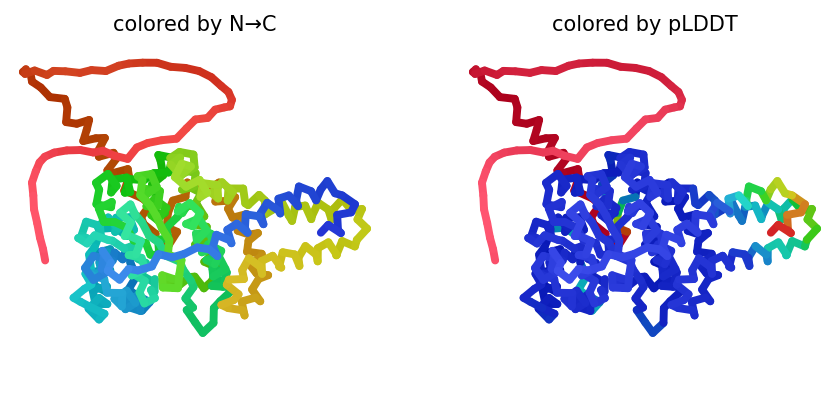

2023-09-15 07:55:14,080 reranking models by 'plddt' metric
2023-09-15 07:55:14,083 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=81.8 pTM=0.791
2023-09-15 07:55:15,422 Query 18/18: RKP13041.1 (length 483)


2023-09-15 07:55:15,863 Sleeping for 6s. Reason: PENDING


2023-09-15 07:55:16,068 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:55:22,300 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:55:26,474 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:55:30,697 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:55:34,837 Sleeping for 8s. Reason: RUNNING


2023-09-15 07:55:37,146 Sleeping for 10s. Reason: RUNNING


2023-09-15 07:55:43,221 Sleeping for 5s. Reason: RUNNING


2023-09-15 07:55:47,523 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:28 remaining: 00:00]


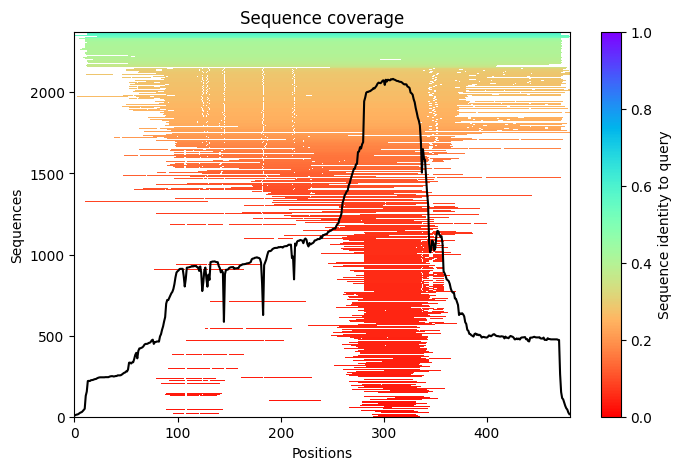

2023-09-15 07:55:55,575 Padding length to 491


2023-09-15 07:55:57,962 Sleeping for 6s. Reason: RUNNING


2023-09-15 07:56:04,406 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:00 remaining: 00:00]


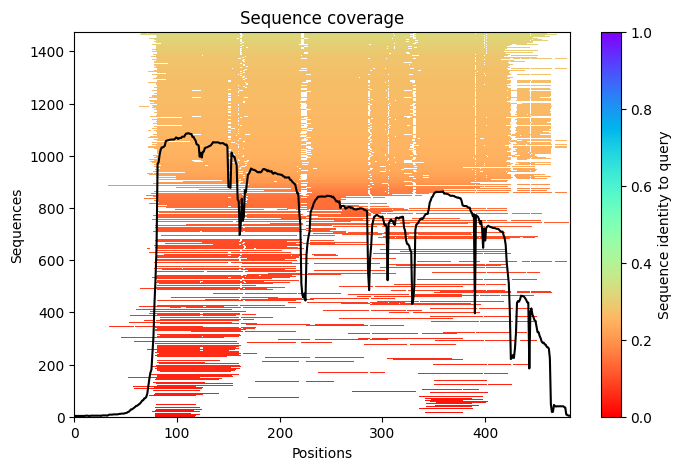

2023-09-15 07:57:11,301 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=89.2 pTM=0.855
2023-09-15 07:58:30,145 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=90.6 pTM=0.871 tol=0.568
2023-09-15 07:59:48,491 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=90.6 pTM=0.87 tol=0.142
2023-09-15 08:01:06,879 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=90.8 pTM=0.872 tol=0.136
2023-09-15 08:01:06,890 alphafold2_ptm_model_1_seed_000 took 311.3s (3 recycles)


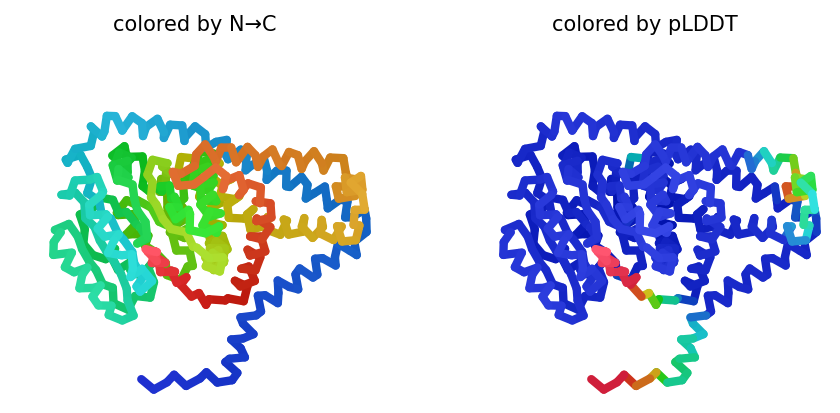

2023-09-15 08:01:08,197 reranking models by 'plddt' metric
2023-09-15 08:01:08,217 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=90.8 pTM=0.872
2023-09-15 08:01:11,939 Query 16/17: KAE8214799.1 (length 492)


2023-09-15 08:01:12,602 Sleeping for 5s. Reason: PENDING


2023-09-15 08:01:18,070 Sleeping for 5s. Reason: RUNNING


2023-09-15 08:01:23,724 Sleeping for 8s. Reason: RUNNING


2023-09-15 08:01:32,340 Sleeping for 6s. Reason: RUNNING


2023-09-15 08:01:38,829 Sleeping for 6s. Reason: RUNNING


2023-09-15 08:01:45,442 Sleeping for 9s. Reason: RUNNING


2023-09-15 08:01:54,950 Sleeping for 10s. Reason: RUNNING


2023-09-15 08:02:05,533 Sleeping for 10s. Reason: RUNNING


2023-09-15 08:02:16,097 Sleeping for 9s. Reason: RUNNING


2023-09-15 08:02:25,531 Sleeping for 7s. Reason: RUNNING


2023-09-15 08:02:33,104 Sleeping for 9s. Reason: RUNNING


RUNNING:  50%|█████     | 75/150 [elapsed: 01:21 remaining: 01:19]

2023-09-15 08:02:39,474 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.5 pTM=0.746


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:31 remaining: 00:00]


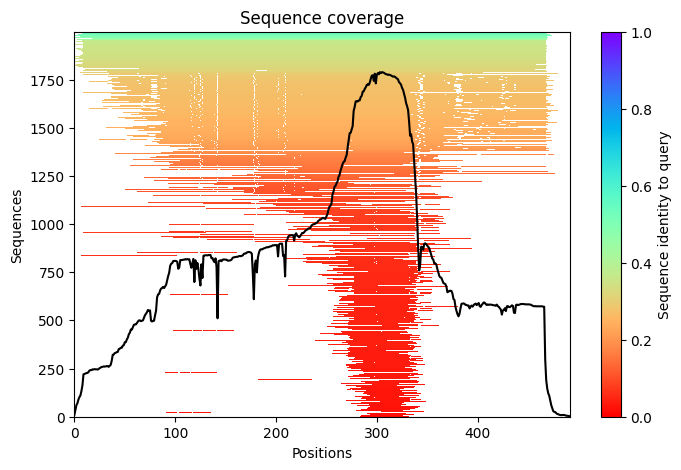

2023-09-15 08:02:51,831 Padding length to 495
2023-09-15 08:03:53,797 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=79 pTM=0.768 tol=2.44
2023-09-15 08:05:10,459 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=78.8 pTM=0.765 tol=0.944
2023-09-15 08:06:26,873 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=79.3 pTM=0.767 tol=0.797
2023-09-15 08:06:26,892 alphafold2_ptm_model_1_seed_000 took 606.1s (3 recycles)


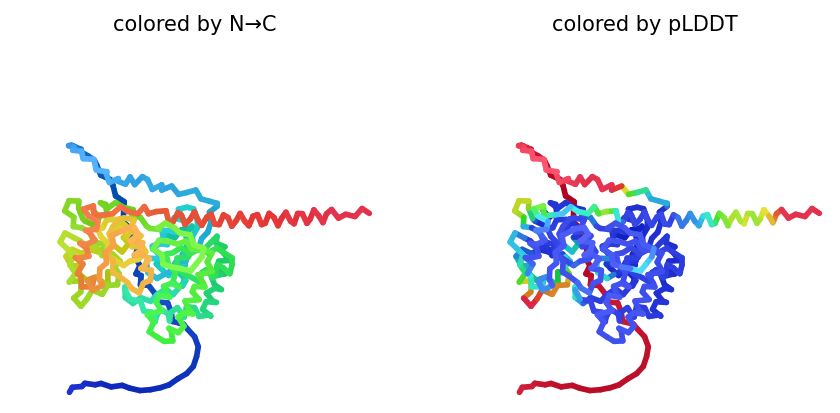

2023-09-15 08:06:28,174 reranking models by 'plddt' metric
2023-09-15 08:06:28,196 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=79.3 pTM=0.767
2023-09-15 08:06:32,095 Done
2023-09-15 08:08:07,279 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=86.9 pTM=0.846
2023-09-15 08:09:19,279 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.8 pTM=0.857 tol=2.69
2023-09-15 08:10:31,273 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=88.1 pTM=0.858 tol=0.31
2023-09-15 08:11:43,692 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=88.4 pTM=0.86 tol=0.28
2023-09-15 08:11:43,703 alphafold2_ptm_model_1_seed_000 took 531.9s (3 recycles)


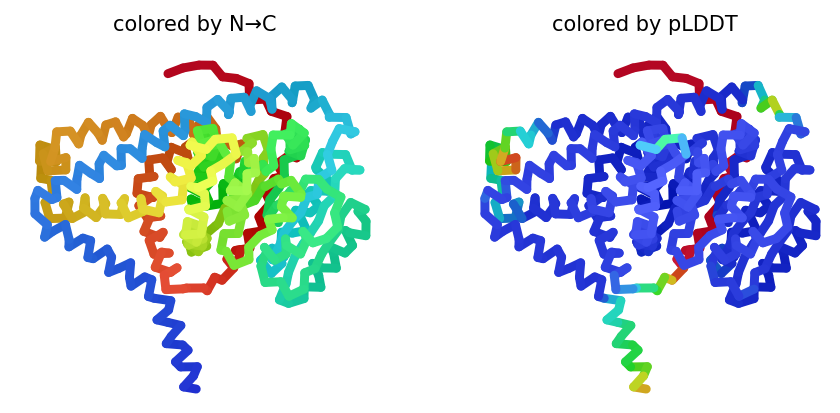

2023-09-15 08:11:44,804 reranking models by 'plddt' metric
2023-09-15 08:11:44,808 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=88.4 pTM=0.86
2023-09-15 08:11:46,289 Query 17/17: KAE8208549.1 (length 495)


2023-09-15 08:11:46,749 Sleeping for 5s. Reason: PENDING


2023-09-15 08:11:52,115 Sleeping for 6s. Reason: RUNNING


2023-09-15 08:11:58,552 Sleeping for 5s. Reason: RUNNING


2023-09-15 08:12:03,953 Sleeping for 7s. Reason: RUNNING


2023-09-15 08:12:11,385 Sleeping for 10s. Reason: RUNNING


2023-09-15 08:12:21,779 Sleeping for 6s. Reason: RUNNING


2023-09-15 08:12:28,176 Sleeping for 5s. Reason: RUNNING


2023-09-15 08:12:33,589 Sleeping for 7s. Reason: RUNNING


2023-09-15 08:12:41,020 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:03 remaining: 00:00]


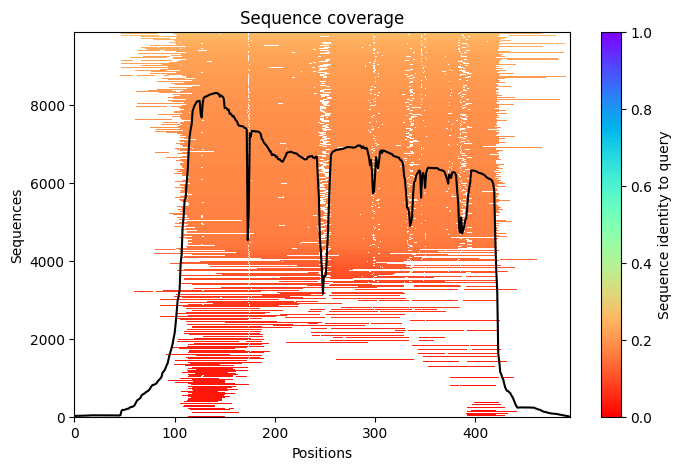

2023-09-15 08:14:15,538 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.3 pTM=0.708
2023-09-15 08:15:28,153 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=71.1 pTM=0.719 tol=5.34
2023-09-15 08:16:40,427 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=70.6 pTM=0.72 tol=9.43
2023-09-15 08:17:52,849 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.1 pTM=0.725 tol=4.54
2023-09-15 08:17:52,856 alphafold2_ptm_model_1_seed_000 took 291.2s (3 recycles)


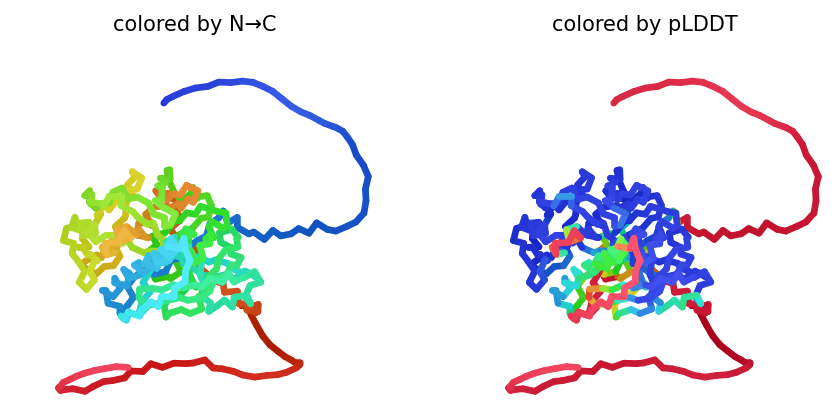

2023-09-15 08:17:53,568 reranking models by 'plddt' metric
2023-09-15 08:17:53,571 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.1 pTM=0.725
2023-09-15 08:17:55,160 Done


In [ ]:
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
import multiprocessing
import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

#############
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - `none` = no template information is used. `pdb70` = detect templates in pdb70. `custom` - upload and search own templates (PDB or mmCIF format, see [notes below](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False
##########

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

# List of all generated jobnames
jobname_list = []
##################################################################
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

def process_sequences(uploaded_content):
    sequences = []
    current_seq = ''
    current_id = ''
    for line in uploaded_content.splitlines():
        if line.startswith('>'):
            if current_seq != '':
                sequences.append((current_id, current_seq))
                current_seq = ''
            current_id = line.strip().replace('>', '')
        else:
            current_seq += line.strip().replace(' ', '')
    sequences.append((current_id, current_seq))
    return sequences

# Upload multiple input files
uploaded_files = files.upload()

for input_filename, uploaded_content in uploaded_files.items():
    # Process sequences from the uploaded content
    sequences = process_sequences(uploaded_content.decode())

    # Create jobname based on input file name
    basejobname = re.sub(r'\W+', '', os.path.splitext(input_filename)[0])
    jobname = add_hash(basejobname, ''.join([seq[1] for seq in sequences]))

    # Check and modify jobname if necessary
    def check(folder):
        return not os.path.exists(folder)

    if not check(jobname):
        n = 0
        while not check(f"{jobname}_{n}"):
            n += 1
        jobname = f"{jobname}_{n}"

    # Create a directory to save results
    os.makedirs(jobname, exist_ok=True)

    # Save queries
    queries_path = os.path.join(jobname, f"{jobname}.csv")
    with open(queries_path, "w") as text_file:
        text_file.write("id,sequence\n")
        for i, seq in enumerate(sequences):
            text_file.write(f"{seq[0]},{seq[1]}\n")

    print("Processed:", input_filename)
    print("Jobname:", jobname)
    print("Num_sequences:", len(sequences))
    print("=" * 40)


    jobname_list.append(jobname)
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

logging_setup = False

def process_prediction(jobname, model_type):
    global logging_setup
    result_dir = jobname

    if not logging_setup:
        setup_logging(Path(os.path.join(jobname, "log.txt")))
        logging_setup = True

    queries, is_complex = get_queries(os.path.join(jobname, f"{jobname}.csv"))
    model_type = set_model_type(is_complex, model_type)

    if "multimer" in model_type and max_msa is not None:
        use_cluster_profile = False
    else:
        use_cluster_profile = True

    download_alphafold_params(model_type, Path("."))
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        num_models=1,
        num_recycles=num_recycles,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        model_order=[1,2,3,4,5],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        use_cluster_profile=use_cluster_profile,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
    )
    result_zip = f"{jobname}.result.zip"
    os.system(f"zip -r {result_zip} {jobname}")

    if save_to_google_drive == True and drive:
        uploaded = drive.CreateFile({'title': result_zip})
        uploaded.SetContentFile(result_zip)
        uploaded.Upload()
        print(f"Uploaded {result_zip} to Google Drive with ID {uploaded.get('id')}")

if __name__ == '__main__':
    workers_limit = 3  # Número máximo de trabajos en paralelo
    with multiprocessing.Pool(processes=workers_limit) as pool:
        pool.starmap(process_prediction, [(jobname, model_type) for jobname in jobname_list])

# Bucle para iterar a través de los jobname y empaquetar las salidas
for jobname in jobname_list:
    if msa_mode == "custom":
        print("Don't forget to cite your custom MSA generation method.")

    result_zip = f"{jobname}.result.zip"
    os.system(f"zip -r {result_zip} {jobname}")

    # Descargar el archivo ZIP de resultados
    files.download(result_zip)

    if save_to_google_drive == True and drive:
        uploaded = drive.CreateFile({'title': result_zip})
        uploaded.SetContentFile(result_zip)
        uploaded.Upload()
        print(f"Uploaded {result_zip} to Google Drive with ID {uploaded.get('id')}")

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and Alphafold2 colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [preprint](https://www.biorxiv.org/content/10.1101/2021.08.15.456425v1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
